# Simulate MPS Encoding Schemes

use qsp_main6

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl

import quimb.tensor as qtn

from qsp.misc_states import make_aklt_mps
from qsp.misc_states import make_aklt_peps
from qsp.tsp import MPSPreparation, PEPSPreparation
from qsp.tsp_helper_routines import make_splitted_mps

c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\qsp\tsp.py:10: FutureWarning: The `qiskit` package is not installed, only `qiskit-terra` is installed. Starting in Qiskit 1.0.0 only the `qiskit` package will be published. Migrate any requirements files still using `qiskit-terra` to use `qiskit` instead. See https://qisk.it/1-0-packaging-migration for more detail.
  import qiskit


### Example Usage

Generate cheby polynomial

In [3]:
from numpy.polynomial.chebyshev import chebval

def generate_piecewise_chebyshev(domain, num_subintervals, degree, seed=None):
    """
    Generates a piecewise Chebyshev polynomial function ensuring continuity at knots.

    Parameters:
    - domain: tuple, the interval (a, b)
    - num_subintervals: int, number of subintervals
    - degree: int, degree of Chebyshev polynomials on each subinterval
    - seed: int or None, random seed for reproducibility

    Returns:
    - func: callable, the piecewise Chebyshev polynomial function
    - knots: numpy array, the partition points
    """
    if seed is not None:
        np.random.seed(seed)
    
    a, b = domain
    knots = np.linspace(a, b, num_subintervals + 1)
    polynomials = []
    
    # Initialize previous value for continuity
    prev_val = 0
    
    for i in range(num_subintervals):
        # Generate random coefficients for Chebyshev polynomial of given degree
        # Coefficients are in the Chebyshev basis
        coeffs = np.random.randn(degree + 1)
        
        # Create Chebyshev polynomial over [-1, 1]
        # To map to [knots[i], knots[i+1]], use linear transformation
        # x_mapped = (2x - (b + a)) / (b - a)
        # Here, a = knots[i], b = knots[i+1]
        def chebyshev_poly(x, coeffs=coeffs, a=knots[i], b=knots[i+1]):
            # Map x from [a, b] to [-1, 1]
            x_mapped = (2 * x - (b + a)) / (b - a)
            y = chebval(x_mapped, coeffs)
            return y
        
        # To ensure continuity, adjust the constant term so that P(a) = prev_val
        # P(a) = chebval(-1, coeffs) = sum_{k=0}^degree c_k T_k(-1)
        # Compute sum_{k=0}^degree c_k T_k(-1)
        T = np.cos(np.pi * np.arange(degree +1))  # T_k(-1) = (-1)^k
        poly_at_a = np.dot(coeffs, T)
        coeffs_adjusted = coeffs.copy()
        coeffs_adjusted[0] += prev_val - poly_at_a  # Adjust c0
        
        polynomials.append((coeffs_adjusted, knots[i], knots[i+1]))
        
        # Update prev_val to P(b)
        # P(b) = chebval(1, coeffs) = sum_{k=0}^degree c_k T_k(1) = c0 + c1 + ... + c_degree
        poly_at_b = np.dot(coeffs_adjusted, np.ones(degree +1))  # T_k(1) = 1
        prev_val = poly_at_b
    
    def func(x):
        """
        Evaluates the piecewise Chebyshev polynomial at x.

        Parameters:
        - x: float or numpy array

        Returns:
        - y: float or numpy array
        """
        x = np.array(x)
        y = np.zeros_like(x, dtype=np.float64)
        
        for coeffs, a, b in polynomials:
            mask = (x >= a) & (x <= b) if a != knots[-1] else (x >= a) & (x <= b + 1e-12)
            x_mapped = (2 * x[mask] - (b + a)) / (b - a)
            y[mask] = chebval(x_mapped, coeffs)
        
        return y
    
    return func, knots

Simple Example and Demonstration of Usage

In [ ]:
#define polynomial
degree=4
intervals = 1

n = 12 #num qubits
L = 8 #num circuit layers

#Create the state vector of length 2**n (coud be any state vector or it could be approximated).
cheby, knots = generate_piecewise_chebyshev((-1,1),num_subintervals=intervals,degree=degree,seed=42)
state_vector = np.array([cheby(x) for x in np.linspace(-1,1,2**n)], dtype=complex)

#Generate the MPS
target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')  

#Encode via Ran
overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=L)

#Encode via Ran+Opt
overlap_opt, circ_opt = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=L,max_iterations=400)

#circ is a Qiskit circuit -> it can be used for further analysis of the state.
#FOR EXAMPLE:

gate_counts = circ.count_ops()
cnot_count = gate_counts.get('cx', 0)
circuit_depth = circ.depth()

#etc. It could also be used to reconstruct the state vector for visualisation.

# EXTENSIVE TESTING (FULL DATA COLLECTION< ASSORTED STATES):

new data

In [5]:
#BOND DIMENSION OF 4 (8 QUBITS HIGHER LAYERS)

#8 QUBITS.

target_mps4 = qtn.MPS_rand_state(L=12, bond_dim=10)
print(type(target_mps4))

target_mps_prep4 = MPSPreparation(target_mps4,shape='lrp')   
for layers in range(1,601,50):
    overlap, circ = target_mps_prep4.sequential_unitary_circuit(num_seq_layers=layers)

    print(circ.depth())
    gate_counts = circ.count_ops()
    cnot_count = gate_counts.get('cx', 0)
    print(cnot_count)

<class 'quimb.tensor.tensor_1d.MatrixProductState'>
preparing mps using sequential unitaries (num_seq_layers=1)...


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 21.76it/s]


overlap from static seq. preparation = 0.5151377782102272 (from circ 0.5151377782102269),
n_gates=90, n_2qg=26

53
26
preparing mps using sequential unitaries (num_seq_layers=51)...


 47%|████▋     | 24/51 [00:01<00:02, 12.45it/s]


KeyboardInterrupt: 

### Chebby Piecewise Polynomials

In [8]:
from numpy.polynomial.chebyshev import chebval

def generate_piecewise_chebyshev(domain, num_subintervals, degree, seed=None):
    """
    Generates a piecewise Chebyshev polynomial function ensuring continuity at knots.

    Parameters:
    - domain: tuple, the interval (a, b)
    - num_subintervals: int, number of subintervals
    - degree: int, degree of Chebyshev polynomials on each subinterval
    - seed: int or None, random seed for reproducibility

    Returns:
    - func: callable, the piecewise Chebyshev polynomial function
    - knots: numpy array, the partition points
    """
    if seed is not None:
        np.random.seed(seed)
    
    a, b = domain
    knots = np.linspace(a, b, num_subintervals + 1)
    polynomials = []
    
    # Initialize previous value for continuity
    prev_val = 0
    
    for i in range(num_subintervals):
        # Generate random coefficients for Chebyshev polynomial of given degree
        # Coefficients are in the Chebyshev basis
        coeffs = np.random.randn(degree + 1)
        
        # Create Chebyshev polynomial over [-1, 1]
        # To map to [knots[i], knots[i+1]], use linear transformation
        # x_mapped = (2x - (b + a)) / (b - a)
        # Here, a = knots[i], b = knots[i+1]
        def chebyshev_poly(x, coeffs=coeffs, a=knots[i], b=knots[i+1]):
            # Map x from [a, b] to [-1, 1]
            x_mapped = (2 * x - (b + a)) / (b - a)
            y = chebval(x_mapped, coeffs)
            return y
        
        # To ensure continuity, adjust the constant term so that P(a) = prev_val
        # P(a) = chebval(-1, coeffs) = sum_{k=0}^degree c_k T_k(-1)
        # Compute sum_{k=0}^degree c_k T_k(-1)
        T = np.cos(np.pi * np.arange(degree +1))  # T_k(-1) = (-1)^k
        poly_at_a = np.dot(coeffs, T)
        coeffs_adjusted = coeffs.copy()
        coeffs_adjusted[0] += prev_val - poly_at_a  # Adjust c0
        
        polynomials.append((coeffs_adjusted, knots[i], knots[i+1]))
        
        # Update prev_val to P(b)
        # P(b) = chebval(1, coeffs) = sum_{k=0}^degree c_k T_k(1) = c0 + c1 + ... + c_degree
        poly_at_b = np.dot(coeffs_adjusted, np.ones(degree +1))  # T_k(1) = 1
        prev_val = poly_at_b
    
    def func(x):
        """
        Evaluates the piecewise Chebyshev polynomial at x.

        Parameters:
        - x: float or numpy array

        Returns:
        - y: float or numpy array
        """
        x = np.array(x)
        y = np.zeros_like(x, dtype=np.float64)
        
        for coeffs, a, b in polynomials:
            mask = (x >= a) & (x <= b) if a != knots[-1] else (x >= a) & (x <= b + 1e-12)
            x_mapped = (2 * x[mask] - (b + a)) / (b - a)
            y[mask] = chebval(x_mapped, coeffs)
        
        return y
    
    return func, knots

In [6]:
cheby, knots = generate_piecewise_chebyshev((-1,1),10,4,seed=42)

chebby_circs = []
chebby_fidelities = []

n = 8

state_vector = np.array([cheby(x) for x in np.linspace(-1,1,2**n)], dtype=complex)

print(state_vector)

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')  

for L in ([1,2] + list(range(4,104,4))):
    overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=L)

    chebby_fidelities.append(overlap)
    chebby_circs.append(circ)

NameError: name 'generate_piecewise_chebyshev' is not defined

In [33]:
for i in chebby_circs:
    gate_counts = i.count_ops()
    cnot_count = gate_counts.get('cx', 0)
    print(cnot_count)

38
73
143
283
432
588
740
895
1048
1200
1351
1502
1656
1809
1957
2108
2258
2402
2559
2708
2859
3010
3169
3308
3468
3620
3763


In [10]:
cheby, knots = generate_piecewise_chebyshev((-1,1),5,5,seed=42)

chebby_opt_circs = []
chebby_opt_fidelities = []

n = 12

state_vector = np.array([cheby(x) for x in np.linspace(-1,1,2**n)], dtype=complex)

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')  

for L in [4,8,12,16,20,24,28,32]:
    overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=L)

    chebby_opt_fidelities.append(overlap)
    chebby_opt_circs.append(circ)

doing variational optimization over sequential unitaries (num_var_seq_layers=4)...


100%|██████████| 4/4 [00:00<00:00, 18.17it/s]


number of variational params in the circuit (from sequential algorithm) are 918
overlap before variational optimization = -0.9974029064


-0.999407351017 [best: -0.999407470226] : : 636it [29:58,  2.83s/it]                       


overllap after variational optimization = 0.9994074702262878 (from circ 0.9994080542951024),
n_gates=333, n_2qg=107

doing variational optimization over sequential unitaries (num_var_seq_layers=8)...


100%|██████████| 8/8 [00:00<00:00, 18.71it/s]


number of variational params in the circuit (from sequential algorithm) are 1920
overlap before variational optimization = -0.9992756248


-0.999530017376 [best: -0.999613046646] :  90%|█████████ | 361/400 [35:32<03:50,  5.91s/it]


overllap after variational optimization = 0.9996130466461182 (from circ 0.9996151699076823),
n_gates=696, n_2qg=228

doing variational optimization over sequential unitaries (num_var_seq_layers=12)...


100%|██████████| 12/12 [00:00<00:00, 20.02it/s]


number of variational params in the circuit (from sequential algorithm) are 2844
overlap before variational optimization = -0.9996389747


-0.999649584293 [best: -0.999811708927] :  76%|███████▌  | 303/400 [43:30<13:55,  8.61s/it]


overllap after variational optimization = 0.9998117089271545 (from circ 0.9998140643289021),
n_gates=1020, n_2qg=336

doing variational optimization over sequential unitaries (num_var_seq_layers=16)...


100%|██████████| 16/16 [00:01<00:00, 14.65it/s]


number of variational params in the circuit (from sequential algorithm) are 3798


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.p

KeyboardInterrupt: 

In [14]:
cheby, knots = generate_piecewise_chebyshev((-1,1),10,4,seed=42)

chebby_opt_circs = []
chebby_opt_fidelities = []

n = 16

state_vector = np.array([cheby(x) for x in np.linspace(-1,1,2**n)], dtype=complex)

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')  

for L in [16,20,24,28]:
    overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=L)

    chebby_opt_fidelities.append(overlap)
    chebby_opt_circs.append(circ)

doing variational optimization over sequential unitaries (num_var_seq_layers=16)...


100%|██████████| 16/16 [00:01<00:00, 12.22it/s]


number of variational params in the circuit (from sequential algorithm) are 4872


KeyboardInterrupt: 

KeyboardInterrupt: 

In [44]:
cheby, knots = generate_piecewise_chebyshev((-1,1),10,4,seed=42)

chebby_opt_circs = []
chebby_opt_fidelities = []

n = 16

state_vector = np.array([cheby(x) for x in np.linspace(-1,1,2**n)], dtype=complex)

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')  

for L in [16]:
    overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=L)

    chebby_opt_fidelities.append(overlap)
    chebby_opt_circs.append(circ)

doing variational optimization over sequential unitaries (num_var_seq_layers=16)...


100%|██████████| 16/16 [00:01<00:00,  9.69it/s]


number of variational params in the circuit (from sequential algorithm) are 4872
overlap before variational optimization = -0.9993128777


-0.999679267406 [best: -0.999762654305] : : 550it [3:08:16, 20.54s/it]                       


overllap after variational optimization = 0.9997626543045044 (from circ 0.9997698592211349),
n_gates=1774, n_2qg=586



c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


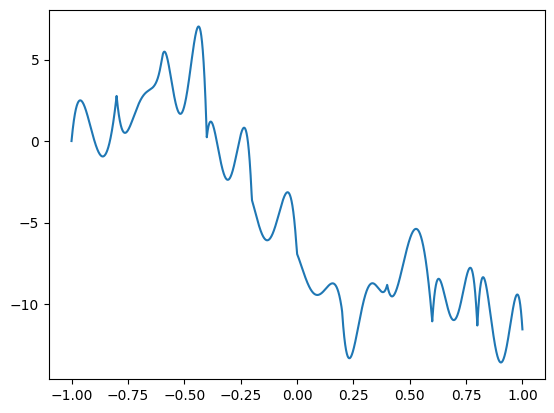

In [30]:
plt.plot(np.linspace(-1,1,2**n),state_vector)

(10,10)

In [41]:
cheby, knots = generate_piecewise_chebyshev((-1,1),10,10,seed=42)
n = 16

state_vector = np.array([cheby(x) for x in np.linspace(-1,1,2**n)], dtype=complex)

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')  

for L in [1,2,4,8,12]:
    overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=L)

    chebby_opt_fidelities.append(overlap)
    chebby_opt_circs.append(circ)

doing variational optimization over sequential unitaries (num_var_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00, 13.99it/s]


number of variational params in the circuit (from sequential algorithm) are 315
overlap before variational optimization = -0.9484304190


-0.950170934200 [best: -0.950222253799] :  62%|██████▏   | 248/400 [03:47<02:19,  1.09it/s]


overllap after variational optimization = 0.9502222537994385 (from circ 0.9502222046357495),
n_gates=127, n_2qg=37

doing variational optimization over sequential unitaries (num_var_seq_layers=2)...


100%|██████████| 2/2 [00:00<00:00,  9.08it/s]


number of variational params in the circuit (from sequential algorithm) are 642
overlap before variational optimization = -0.9606365561


-0.973485946655 [best: -0.973556816578] : : 507it [16:38,  1.97s/it]                       


overllap after variational optimization = 0.9735568165779114 (from circ 0.9735563983631683),
n_gates=244, n_2qg=76

doing variational optimization over sequential unitaries (num_var_seq_layers=4)...


100%|██████████| 4/4 [00:00<00:00,  8.92it/s]


number of variational params in the circuit (from sequential algorithm) are 1260
overlap before variational optimization = -0.9718194604


-0.987225830555 [best: -0.993028938770] : : 521it [32:44,  3.77s/it]                       


overllap after variational optimization = 0.9930289387702942 (from circ 0.9873009821446906),
n_gates=460, n_2qg=148

doing variational optimization over sequential unitaries (num_var_seq_layers=8)...


100%|██████████| 8/8 [00:00<00:00,  8.93it/s]


number of variational params in the circuit (from sequential algorithm) are 2616
overlap before variational optimization = -0.9865306616


-0.998359262943 [best: -0.998359262943] : : 687it [1:25:27,  7.46s/it]                     


overllap after variational optimization = 0.9983592629432678 (from circ 0.9983647951970933),
n_gates=952, n_2qg=312

doing variational optimization over sequential unitaries (num_var_seq_layers=12)...


100%|██████████| 12/12 [00:01<00:00,  7.67it/s]


number of variational params in the circuit (from sequential algorithm) are 3978
overlap before variational optimization = -0.9922172427


-0.998760759830 [best: -0.999301791191] : : 737it [2:20:10, 11.41s/it]                       


overllap after variational optimization = 0.9993017911911011 (from circ 0.9993071938619144),
n_gates=1447, n_2qg=477



In [46]:
cheby, knots = generate_piecewise_chebyshev((-1,1),10,10,seed=42)

n = 16

state_vector = np.array([cheby(x) for x in np.linspace(-1,1,2**n)], dtype=complex)

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')  

for L in [16]:
    overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=L)

    chebby_opt_fidelities.append(overlap)
    chebby_opt_circs.append(circ)

doing variational optimization over sequential unitaries (num_var_seq_layers=16)...


100%|██████████| 16/16 [00:02<00:00,  7.11it/s]


number of variational params in the circuit (from sequential algorithm) are 5406
overlap before variational optimization = -0.9949926138


-0.999307870865 [best: -0.999307870865] : : 743it [3:32:10, 17.13s/it]                       


overllap after variational optimization = 0.9993078708648682 (from circ 0.9993145899200202),
n_gates=1975, n_2qg=653



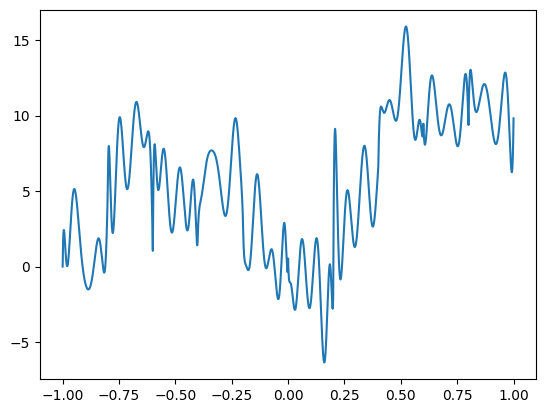

preparing mps using sequential unitaries (num_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


overlap from static seq. preparation = 0.9484313419060413 (from circ 0.9484313419060406),
n_gates=127, n_2qg=37

preparing mps using sequential unitaries (num_seq_layers=2)...


100%|██████████| 2/2 [00:00<00:00, 13.24it/s]


overlap from static seq. preparation = 0.9606380023697166 (from circ 0.9606380023479331),
n_gates=244, n_2qg=76

preparing mps using sequential unitaries (num_seq_layers=4)...


100%|██████████| 4/4 [00:00<00:00, 11.76it/s]


overlap from static seq. preparation = 0.9718231307984260 (from circ 0.9718231806450059),
n_gates=460, n_2qg=148

preparing mps using sequential unitaries (num_seq_layers=8)...


100%|██████████| 8/8 [00:00<00:00,  9.76it/s]


overlap from static seq. preparation = 0.9865358565008409 (from circ 0.9865358797894606),
n_gates=952, n_2qg=312

preparing mps using sequential unitaries (num_seq_layers=12)...


100%|██████████| 12/12 [00:01<00:00,  8.36it/s]


overlap from static seq. preparation = 0.9922235332347492 (from circ 0.9922235926661740),
n_gates=1447, n_2qg=477

preparing mps using sequential unitaries (num_seq_layers=16)...


100%|██████████| 16/16 [00:02<00:00,  7.38it/s]


overlap from static seq. preparation = 0.9948459929253877 (from circ 0.9948460271346830),
n_gates=2017, n_2qg=667

preparing mps using sequential unitaries (num_seq_layers=20)...


100%|██████████| 20/20 [00:02<00:00,  6.95it/s]


overlap from static seq. preparation = 0.9964610245324326 (from circ 0.9964610033594680),
n_gates=2518, n_2qg=834

preparing mps using sequential unitaries (num_seq_layers=24)...


100%|██████████| 24/24 [00:03<00:00,  6.33it/s]


overlap from static seq. preparation = 0.9972542662472674 (from circ 0.9972543170236322),
n_gates=3091, n_2qg=1025

preparing mps using sequential unitaries (num_seq_layers=28)...


100%|██████████| 28/28 [00:04<00:00,  5.86it/s]


overlap from static seq. preparation = 0.9977661886914464 (from circ 0.9977662719828893),
n_gates=3631, n_2qg=1205

preparing mps using sequential unitaries (num_seq_layers=32)...


100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


overlap from static seq. preparation = 0.9982984612185493 (from circ 0.9982985449695647),
n_gates=4168, n_2qg=1384

preparing mps using sequential unitaries (num_seq_layers=36)...


100%|██████████| 36/36 [00:06<00:00,  5.31it/s]


overlap from static seq. preparation = 0.9985132323687346 (from circ 0.9985133063612676),
n_gates=4702, n_2qg=1562

preparing mps using sequential unitaries (num_seq_layers=40)...


100%|██████████| 40/40 [00:07<00:00,  5.10it/s]


overlap from static seq. preparation = 0.9988769132643921 (from circ 0.9988769721709856),
n_gates=5242, n_2qg=1742

preparing mps using sequential unitaries (num_seq_layers=44)...


100%|██████████| 44/44 [00:09<00:00,  4.74it/s]


overlap from static seq. preparation = 0.9991411881788969 (from circ 0.9991412838608488),
n_gates=5770, n_2qg=1918

preparing mps using sequential unitaries (num_seq_layers=48)...


100%|██████████| 48/48 [00:10<00:00,  4.56it/s]


overlap from static seq. preparation = 0.9991851828617594 (from circ 0.9991853274645690),
n_gates=6307, n_2qg=2097

preparing mps using sequential unitaries (num_seq_layers=52)...


100%|██████████| 52/52 [00:11<00:00,  4.46it/s]


overlap from static seq. preparation = 0.9993271081718625 (from circ 0.9993271580096474),
n_gates=6829, n_2qg=2271

preparing mps using sequential unitaries (num_seq_layers=56)...


100%|██████████| 56/56 [00:13<00:00,  4.21it/s]


overlap from static seq. preparation = 0.9994914696981912 (from circ 0.9994915430952215),
n_gates=7336, n_2qg=2440

preparing mps using sequential unitaries (num_seq_layers=60)...


100%|██████████| 60/60 [00:15<00:00,  3.99it/s]


overlap from static seq. preparation = 0.9995329283484655 (from circ 0.9995329907278343),
n_gates=7894, n_2qg=2626

preparing mps using sequential unitaries (num_seq_layers=64)...


100%|██████████| 64/64 [00:16<00:00,  3.92it/s]


overlap from static seq. preparation = 0.9996110226465477 (from circ 0.9996110285592793),
n_gates=8446, n_2qg=2810

preparing mps using sequential unitaries (num_seq_layers=68)...


100%|██████████| 68/68 [00:17<00:00,  3.84it/s]


overlap from static seq. preparation = 0.9996301298806241 (from circ 0.9996302401859521),
n_gates=8953, n_2qg=2979

preparing mps using sequential unitaries (num_seq_layers=72)...


100%|██████████| 72/72 [00:19<00:00,  3.67it/s]


overlap from static seq. preparation = 0.9997248512119020 (from circ 0.9997249210071208),
n_gates=9484, n_2qg=3156

preparing mps using sequential unitaries (num_seq_layers=76)...


100%|██████████| 76/76 [00:21<00:00,  3.55it/s]


overlap from static seq. preparation = 0.9997449303776472 (from circ 0.9997450353382615),
n_gates=10015, n_2qg=3333

preparing mps using sequential unitaries (num_seq_layers=80)...


100%|██████████| 80/80 [00:23<00:00,  3.37it/s]


overlap from static seq. preparation = 0.9997838926032366 (from circ 0.9997839921718970),
n_gates=10522, n_2qg=3502

preparing mps using sequential unitaries (num_seq_layers=84)...


100%|██████████| 84/84 [00:25<00:00,  3.31it/s]


overlap from static seq. preparation = 0.9997947605896954 (from circ 0.9997948248132553),
n_gates=11059, n_2qg=3681

preparing mps using sequential unitaries (num_seq_layers=88)...


100%|██████████| 88/88 [00:28<00:00,  3.12it/s]


overlap from static seq. preparation = 0.9998356220046674 (from circ 0.9998355741669421),
n_gates=11542, n_2qg=3842

preparing mps using sequential unitaries (num_seq_layers=92)...


100%|██████████| 92/92 [00:29<00:00,  3.09it/s]


overlap from static seq. preparation = 0.9998449071033760 (from circ 0.9998448782577206),
n_gates=11920, n_2qg=3968

preparing mps using sequential unitaries (num_seq_layers=96)...


100%|██████████| 96/96 [00:32<00:00,  2.98it/s]


overlap from static seq. preparation = 0.9998638682282879 (from circ 0.9998638574808819),
n_gates=12496, n_2qg=4160

preparing mps using sequential unitaries (num_seq_layers=100)...


100%|██████████| 100/100 [00:34<00:00,  2.86it/s]


overlap from static seq. preparation = 0.9998708877272543 (from circ 0.9998708995625931),
n_gates=13024, n_2qg=4336



In [36]:
cheby, knots = generate_piecewise_chebyshev((-1,1),10,10,seed=42)

chebby_circs = []
chebby_fidelities = []

n = 16

state_vector = np.array([cheby(x) for x in np.linspace(-1,1,2**n)], dtype=complex)

plt.plot(np.linspace(-1,1,2**n),state_vector)

plt.show()

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')  

for L in ([1,2] + list(range(4,104,4))):
    overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=L)

    chebby_fidelities.append(overlap)
    chebby_circs.append(circ)

In [37]:
for i in chebby_circs:
    gate_counts = i.count_ops()
    cnot_count = gate_counts.get('cx', 0)
    print(cnot_count)

37
76
148
312
477
667
834
1025
1205
1384
1562
1742
1918
2097
2271
2440
2626
2810
2979
3156
3333
3502
3681
3842
3968
4160
4336


In [39]:
for i in chebby_circs:
    print(i.depth())


75
87
111
161
213
265
311
361
409
457
505
553
599
649
697
741
791
841
889
937
985
1031
1079
1127
1175
1223
1271


### other

In [4]:
#BOND DIMENSION OF 3 (8 QUBITS HIGHER LAYERS)

#8 QUBITS.


fid_ran3 = []
n_ran3 = []
n2_ran3 = []

fid_opt3 = []
n_opt3 = []
n2_opt3 = []

circs3 = []

target_mps3 = qtn.MPS_rand_state(L=16, bond_dim=4)

target_mps_prep3 = MPSPreparation(target_mps3,shape='lrp')  

for layers in range(1,20,2):
    overlap,circ = target_mps_prep3.sequential_unitary_circuit(num_seq_layers=layers)
    print(circ.depth())


preparing mps using sequential unitaries (num_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


overlap from static seq. preparation = 0.7195567470024938 (from circ 0.7195567470024566),
n_gates=139, n_2qg=41

83
preparing mps using sequential unitaries (num_seq_layers=3)...


100%|██████████| 3/3 [00:00<00:00, 16.27it/s]


overlap from static seq. preparation = 0.8289463328410114 (from circ 0.8289466365313269),
n_gates=379, n_2qg=121

111
preparing mps using sequential unitaries (num_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00,  7.29it/s]


overlap from static seq. preparation = 0.8525122843683819 (from circ 0.8525125712408326),
n_gates=625, n_2qg=203

137
preparing mps using sequential unitaries (num_seq_layers=7)...


100%|██████████| 7/7 [00:01<00:00,  3.68it/s]


overlap from static seq. preparation = 0.8680300521349451 (from circ 0.8680301097339750),
n_gates=916, n_2qg=300

163
preparing mps using sequential unitaries (num_seq_layers=9)...


100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


overlap from static seq. preparation = 0.8752834028306584 (from circ 0.8752832030984161),
n_gates=1171, n_2qg=385

187
preparing mps using sequential unitaries (num_seq_layers=11)...


100%|██████████| 11/11 [00:04<00:00,  2.36it/s]


overlap from static seq. preparation = 0.8821324865674736 (from circ 0.8821326948371544),
n_gates=1357, n_2qg=447

209
preparing mps using sequential unitaries (num_seq_layers=13)...


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


overlap from static seq. preparation = 0.8816176232101430 (from circ 0.8816182081002877),
n_gates=1666, n_2qg=550

235
preparing mps using sequential unitaries (num_seq_layers=15)...


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


overlap from static seq. preparation = 0.8855561979230415 (from circ 0.8855562372405258),
n_gates=1942, n_2qg=642

259
preparing mps using sequential unitaries (num_seq_layers=17)...


100%|██████████| 17/17 [00:08<00:00,  2.03it/s]


overlap from static seq. preparation = 0.8854162735099821 (from circ 0.8854162974069598),
n_gates=2206, n_2qg=730

283
preparing mps using sequential unitaries (num_seq_layers=19)...


100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


overlap from static seq. preparation = 0.8873987488148235 (from circ 0.8873992300900281),
n_gates=2506, n_2qg=830

307


In [5]:
#BOND DIMENSION OF 3 (8 QUBITS HIGHER LAYERS)

#8 QUBITS.


fid_ran3 = []
n_ran3 = []
n2_ran3 = []

fid_opt3 = []
n_opt3 = []
n2_opt3 = []

circs3 = []

target_mps3 = qtn.MPS_rand_state(L=16, bond_dim=5)

target_mps_prep3 = MPSPreparation(target_mps3,shape='lrp')  

for layers in range(1,20,2):
    overlap,circ = target_mps_prep3.sequential_unitary_circuit(num_seq_layers=layers)
    print(circ.depth())


preparing mps using sequential unitaries (num_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00, 10.52it/s]

overlap from static seq. preparation = 0.7843542814526701 (from circ 0.7843542814526694),
n_gates=136, n_2qg=40

81
preparing mps using sequential unitaries (num_seq_layers=3)...



100%|██████████| 3/3 [00:00<00:00, 13.99it/s]


overlap from static seq. preparation = 0.8366491194212400 (from circ 0.8366491194212373),
n_gates=370, n_2qg=118

103
preparing mps using sequential unitaries (num_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00,  6.13it/s]


overlap from static seq. preparation = 0.8606526932196802 (from circ 0.8606527451371282),
n_gates=610, n_2qg=198

127
preparing mps using sequential unitaries (num_seq_layers=7)...


100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


overlap from static seq. preparation = 0.8714037819166223 (from circ 0.8714041076205400),
n_gates=838, n_2qg=274

153
preparing mps using sequential unitaries (num_seq_layers=9)...


100%|██████████| 9/9 [00:03<00:00,  2.97it/s]


overlap from static seq. preparation = 0.8797050614107847 (from circ 0.8797052276403696),
n_gates=1093, n_2qg=359

179
preparing mps using sequential unitaries (num_seq_layers=11)...


100%|██████████| 11/11 [00:04<00:00,  2.45it/s]


overlap from static seq. preparation = 0.8877208913652119 (from circ 0.8877211338866703),
n_gates=1351, n_2qg=445

203
preparing mps using sequential unitaries (num_seq_layers=13)...


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


overlap from static seq. preparation = 0.8912082058432672 (from circ 0.8912082228316996),
n_gates=1633, n_2qg=539

229
preparing mps using sequential unitaries (num_seq_layers=15)...


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


overlap from static seq. preparation = 0.8974268709352943 (from circ 0.8974270401211569),
n_gates=1894, n_2qg=626

253
preparing mps using sequential unitaries (num_seq_layers=17)...


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


overlap from static seq. preparation = 0.9046572307022778 (from circ 0.9046571380349187),
n_gates=2248, n_2qg=744

281
preparing mps using sequential unitaries (num_seq_layers=19)...


100%|██████████| 19/19 [00:09<00:00,  1.99it/s]


overlap from static seq. preparation = 0.9046055286624880 (from circ 0.9046049349773957),
n_gates=2371, n_2qg=785

301


In [6]:
#BOND DIMENSION OF 3 (8 QUBITS HIGHER LAYERS)

#8 QUBITS.


fid_ran3 = []
n_ran3 = []
n2_ran3 = []

fid_opt3 = []
n_opt3 = []
n2_opt3 = []

circs3 = []

target_mps3 = qtn.MPS_rand_state(L=16, bond_dim=10)

target_mps_prep3 = MPSPreparation(target_mps3,shape='lrp')  

for layers in range(1,20,2):
    overlap,circ = target_mps_prep3.sequential_unitary_circuit(num_seq_layers=layers)
    print(circ.depth())


preparing mps using sequential unitaries (num_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


overlap from static seq. preparation = 0.4932691078578496 (from circ 0.4932691078578494),
n_gates=130, n_2qg=38

77
preparing mps using sequential unitaries (num_seq_layers=3)...


100%|██████████| 3/3 [00:00<00:00,  8.47it/s]


overlap from static seq. preparation = 0.5990526582321314 (from circ 0.5990526582321278),
n_gates=367, n_2qg=117

103
preparing mps using sequential unitaries (num_seq_layers=5)...


100%|██████████| 5/5 [00:01<00:00,  3.69it/s]


overlap from static seq. preparation = 0.6395315262653131 (from circ 0.6395315186134822),
n_gates=601, n_2qg=195

125
preparing mps using sequential unitaries (num_seq_layers=7)...


100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


overlap from static seq. preparation = 0.6519132947191116 (from circ 0.6519133121430051),
n_gates=916, n_2qg=300

159
preparing mps using sequential unitaries (num_seq_layers=9)...


100%|██████████| 9/9 [00:03<00:00,  2.28it/s]


overlap from static seq. preparation = 0.6575526915868007 (from circ 0.6575525490751761),
n_gates=1084, n_2qg=356

177
preparing mps using sequential unitaries (num_seq_layers=11)...


100%|██████████| 11/11 [00:05<00:00,  2.12it/s]


overlap from static seq. preparation = 0.6688687364776182 (from circ 0.6688689758150437),
n_gates=1459, n_2qg=481

207
preparing mps using sequential unitaries (num_seq_layers=13)...


100%|██████████| 13/13 [00:06<00:00,  2.05it/s]


overlap from static seq. preparation = 0.6804851427600733 (from circ 0.6804854481337071),
n_gates=1726, n_2qg=570

231
preparing mps using sequential unitaries (num_seq_layers=15)...


100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


overlap from static seq. preparation = 0.6810203411034309 (from circ 0.6810200664497261),
n_gates=1945, n_2qg=643

255
preparing mps using sequential unitaries (num_seq_layers=17)...


100%|██████████| 17/17 [00:09<00:00,  1.79it/s]


overlap from static seq. preparation = 0.6918604607876901 (from circ 0.6918603191706594),
n_gates=2251, n_2qg=745

279
preparing mps using sequential unitaries (num_seq_layers=19)...


100%|██████████| 19/19 [00:10<00:00,  1.73it/s]


overlap from static seq. preparation = 0.6953162336727677 (from circ 0.6953166373538626),
n_gates=2488, n_2qg=824

301


In [8]:
#BOND DIMENSION OF 3 (8 QUBITS HIGHER LAYERS)

#8 QUBITS.


fid_ran3 = []
n_ran3 = []
n2_ran3 = []

fid_opt3 = []
n_opt3 = []
n2_opt3 = []

circs3 = []

target_mps3 = qtn.MPS_rand_state(L=12, bond_dim=10)

target_mps_prep3 = MPSPreparation(target_mps3,shape='lrp')  

for layers in [12,18,24,30]:
    overlap,circ = target_mps_prep3.sequential_unitary_circuit(num_seq_layers=layers)
    print(circ.depth())
    gate_counts = circ.count_ops()
    cnot_count = gate_counts.get('cx', 0)
    print(cnot_count)


preparing mps using sequential unitaries (num_seq_layers=12)...


100%|██████████| 12/12 [00:00<00:00, 16.07it/s]


overlap from static seq. preparation = 0.8137152285332844 (from circ 0.8137151017290499),
n_gates=1167, n_2qg=385

197
385
preparing mps using sequential unitaries (num_seq_layers=18)...


100%|██████████| 18/18 [00:01<00:00, 12.67it/s]


overlap from static seq. preparation = 0.8239028968541158 (from circ 0.8239027858917396),
n_gates=1707, n_2qg=565

269
565
preparing mps using sequential unitaries (num_seq_layers=24)...


100%|██████████| 24/24 [00:01<00:00, 12.03it/s]


overlap from static seq. preparation = 0.8418046345264876 (from circ 0.8418045638258731),
n_gates=2313, n_2qg=767

341
767
preparing mps using sequential unitaries (num_seq_layers=30)...


100%|██████████| 30/30 [00:02<00:00, 10.01it/s]


overlap from static seq. preparation = 0.8560783241283091 (from circ 0.8560784140015583),
n_gates=2928, n_2qg=972

413
972


In [ ]:
#BOND DIMENSION OF 3 (8 QUBITS HIGHER LAYERS)

#8 QUBITS.


fid_ran3 = []
n_ran3 = []
n2_ran3 = []

fid_opt3 = []
n_opt3 = []
n2_opt3 = []

circs3 = []

target_mps3 = qtn.MPS_rand_state(L=16, bond_dim=10)

target_mps_prep3 = MPSPreparation(target_mps3,shape='lrp')  

for layers in range(1,20,2):
    overlap,circ = target_mps_prep3.sequential_unitary_circuit(num_seq_layers=layers)
    print(circ.depth())

In [3]:
#BOND DIMENSION OF 3 (8 QUBITS HIGHER LAYERS)

#8 QUBITS.


fid_ran3 = []
n_ran3 = []
n2_ran3 = []

fid_opt3 = []
n_opt3 = []
n2_opt3 = []

circs3 = []

target_mps3 = qtn.MPS_rand_state(L=16, bond_dim=3)

for layers in [20,22]:
    for i in range(1):
        target_mps_prep3 = MPSPreparation(target_mps3,shape='lrp')   

        overlap, circ = target_mps_prep3.sequential_unitary_circuit(num_seq_layers=layers)

        fid_ran3.append(overlap)
        n_ran3.append(circ.size())
        n2_ran3.append(circ.num_nonlocal_gates())

        overlap, circ = target_mps_prep3.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=300)

        fid_opt3.append(overlap)
        circs3.append(circ)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran3[-1:]))
    print(list(fid_opt3[-1:]))
    print(list(n_ran3[-1:]))
    print(list(n2_ran3[-1:]))

print(fid_ran3)
print(fid_opt3)
print(n_ran3)
print(n2_ran3)

preparing mps using sequential unitaries (num_seq_layers=20)...


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


overlap from static seq. preparation = 0.9660426416727779 (from circ 0.9660428799390229),
n_gates=2578, n_2qg=854

doing variational optimization over sequential unitaries (num_var_seq_layers=20)...


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


number of variational params in the circuit (from sequential algorithm) are 7023


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximu

overlap before variational optimization = -0.9660699964


-0.977272689342 [best: -0.993054330349] : : 622it [3:09:29, 18.28s/it]                       


overllap after variational optimization = 0.9930543303489685 (from circ 0.9930667196594861),
n_gates=2599, n_2qg=861

Layer = 20 done:
[(0.9660426416727765-5.123240429463768e-08j)]
[0.9930543303489685]
[2578]
[854]
preparing mps using sequential unitaries (num_seq_layers=22)...


100%|██████████| 22/22 [00:15<00:00,  1.45it/s]


overlap from static seq. preparation = 0.9670646726100381 (from circ 0.9670648490019990),
n_gates=2773, n_2qg=919

doing variational optimization over sequential unitaries (num_var_seq_layers=22)...


100%|██████████| 22/22 [00:14<00:00,  1.47it/s]


number of variational params in the circuit (from sequential algorithm) are 7662
overlap before variational optimization = -0.9657360911


-0.983956515789 [best: -0.994532346725] : : 620it [8:41:27, 50.46s/it]                             


overllap after variational optimization = 0.9945323467254639 (from circ 0.9945501608902787),
n_gates=2824, n_2qg=936

Layer = 22 done:
[(0.9670646726100379-2.241264958693924e-08j)]
[0.9945323467254639]
[2773]
[919]
[(0.9660426416727765-5.123240429463768e-08j), (0.9670646726100379-2.241264958693924e-08j)]
[0.9930543303489685, 0.9945323467254639]
[2578, 2773]
[854, 919]


In [5]:
#BOND DIMENSION OF 3 (8 QUBITS HIGHER LAYERS)

#8 QUBITS.


fid_ran3 = []
n_ran3 = []
n2_ran3 = []

fid_opt3 = []
n_opt3 = []
n2_opt3 = []

circs3 = []

target_mps3 = qtn.MPS_rand_state(L=16, bond_dim=3)

for layers in [30]:
    for i in range(1):
        target_mps_prep3 = MPSPreparation(target_mps3,shape='lrp')   

        overlap, circ = target_mps_prep3.sequential_unitary_circuit(num_seq_layers=layers)

        fid_ran3.append(overlap)
        n_ran3.append(circ.size())
        n2_ran3.append(circ.num_nonlocal_gates())

        overlap, circ = target_mps_prep3.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=300)

        fid_opt3.append(overlap)
        circs3.append(circ)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran3[-1:]))
    print(list(fid_opt3[-1:]))
    print(list(n_ran3[-1:]))
    print(list(n2_ran3[-1:]))

print(fid_ran3)
print(fid_opt3)
print(n_ran3)
print(n2_ran3)

preparing mps using sequential unitaries (num_seq_layers=30)...


100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


overlap from static seq. preparation = 0.9470490765787943 (from circ 0.9470494986126070),
n_gates=3934, n_2qg=1306

doing variational optimization over sequential unitaries (num_var_seq_layers=30)...


100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


number of variational params in the circuit (from sequential algorithm) are 10533


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: int too large to convert to float. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: int too large to convert to float. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: int too large to convert to float. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: int to

overlap before variational optimization = -0.9473872185


-0.994213759899 [best: -0.994213759899] : : 590it [4:28:58, 27.35s/it]                         


overllap after variational optimization = 0.9942137598991394 (from circ 0.9942876410923129),
n_gates=3892, n_2qg=1292

Layer = 30 done:
[(0.9470490765787245-3.638309611017633e-07j)]
[0.9942137598991394]
[3934]
[1306]
[(0.9470490765787245-3.638309611017633e-07j)]
[0.9942137598991394]
[3934]
[1306]


In [6]:
#BOND DIMENSION OF 3 (8 QUBITS HIGHER LAYERS)

#8 QUBITS.


fid_ran3 = []
n_ran3 = []
n2_ran3 = []

fid_opt3 = []
n_opt3 = []
n2_opt3 = []

circs3 = []

target_mps3 = qtn.MPS_rand_state(L=16, bond_dim=3)

for layers in [3,6,12,15,18,21,24,27,30]:
    for i in range(1):
        target_mps_prep3 = MPSPreparation(target_mps3,shape='lrp')   

        overlap, circ = target_mps_prep3.sequential_unitary_circuit(num_seq_layers=layers)

        fid_ran3.append(overlap)
        n_ran3.append(circ.size())
        n2_ran3.append(circ.num_nonlocal_gates())

        overlap, circ = target_mps_prep3.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=300)

        fid_opt3.append(overlap)
        circs3.append(circ)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran3[-1:]))
    print(list(fid_opt3[-1:]))
    print(list(n_ran3[-1:]))
    print(list(n2_ran3[-1:]))

print(fid_ran3)
print(fid_opt3)
print(n_ran3)
print(n2_ran3)

preparing mps using sequential unitaries (num_seq_layers=3)...


100%|██████████| 3/3 [00:00<00:00, 16.00it/s]


overlap from static seq. preparation = 0.8403287285617573 (from circ 0.8403287285617558),
n_gates=343, n_2qg=109

doing variational optimization over sequential unitaries (num_var_seq_layers=3)...


100%|██████████| 3/3 [00:00<00:00, 17.96it/s]


number of variational params in the circuit (from sequential algorithm) are 933
overlap before variational optimization = -0.8403265476


-0.983646273613 [best: -0.983646273613] : : 559it [22:18,  2.40s/it]                       


overllap after variational optimization = 0.9836462736129761 (from circ 0.9837243522526874),
n_gates=343, n_2qg=109

Layer = 3 done:
[0.8403287285617573]
[0.9836462736129761]
[343]
[109]
preparing mps using sequential unitaries (num_seq_layers=6)...


100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


overlap from static seq. preparation = 0.8771998254354927 (from circ 0.8771999195032650),
n_gates=697, n_2qg=227

doing variational optimization over sequential unitaries (num_var_seq_layers=6)...


100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


number of variational params in the circuit (from sequential algorithm) are 1914
overlap before variational optimization = -0.8771539927


-0.990090548992 [best: -0.990090548992] : : 576it [46:57,  4.89s/it]                       


overllap after variational optimization = 0.9900905489921570 (from circ 0.9901208036120550),
n_gates=694, n_2qg=226

Layer = 6 done:
[0.8771998254354927]
[0.990090548992157]
[697]
[227]
preparing mps using sequential unitaries (num_seq_layers=12)...


100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


overlap from static seq. preparation = 0.8907711415676571 (from circ 0.8907713092976045),
n_gates=1429, n_2qg=471

doing variational optimization over sequential unitaries (num_var_seq_layers=12)...


100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


number of variational params in the circuit (from sequential algorithm) are 3909
overlap before variational optimization = -0.8923163414


-0.990366816521 [best: -0.990366816521] : : 615it [1:52:23, 10.96s/it]                     


overllap after variational optimization = 0.9903668165206909 (from circ 0.9903716695297113),
n_gates=1414, n_2qg=466

Layer = 12 done:
[0.8907711415676571]
[0.9903668165206909]
[1429]
[471]
preparing mps using sequential unitaries (num_seq_layers=15)...


100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


overlap from static seq. preparation = 0.9004186496671029 (from circ 0.9004190161262831),
n_gates=1870, n_2qg=618

doing variational optimization over sequential unitaries (num_var_seq_layers=15)...


100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


number of variational params in the circuit (from sequential algorithm) are 5112


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.p

KeyboardInterrupt: 

In [7]:
for layers in [9,15,18]:
    for i in range(1):
        target_mps_prep3 = MPSPreparation(target_mps3,shape='lrp')   

        overlap, circ = target_mps_prep3.sequential_unitary_circuit(num_seq_layers=layers)

        fid_ran3.append(overlap)
        n_ran3.append(circ.size())
        n2_ran3.append(circ.num_nonlocal_gates())

        overlap, circ = target_mps_prep3.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=300)

        fid_opt3.append(overlap)
        circs3.append(circ)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran3[-1:]))
    print(list(fid_opt3[-1:]))
    print(list(n_ran3[-1:]))
    print(list(n2_ran3[-1:]))

print(fid_ran3)
print(fid_opt3)
print(n_ran3)
print(n2_ran3)

preparing mps using sequential unitaries (num_seq_layers=9)...


100%|██████████| 9/9 [00:02<00:00,  3.13it/s]


overlap from static seq. preparation = 0.8881188694040060 (from circ 0.8881190408539944),
n_gates=1030, n_2qg=338

doing variational optimization over sequential unitaries (num_var_seq_layers=9)...


100%|██████████| 9/9 [00:02<00:00,  3.17it/s]


number of variational params in the circuit (from sequential algorithm) are 2940
overlap before variational optimization = -0.8891205788


-0.988166749477 [best: -0.988166749477] : : 564it [1:23:22,  8.87s/it]                     


overllap after variational optimization = 0.9881667494773865 (from circ 0.9882508472186574),
n_gates=1069, n_2qg=351

Layer = 9 done:
[0.888118869404006]
[0.9881667494773865]
[1030]
[338]
preparing mps using sequential unitaries (num_seq_layers=15)...


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


overlap from static seq. preparation = 0.8907701436773969 (from circ 0.8907700968913141),
n_gates=1849, n_2qg=611

doing variational optimization over sequential unitaries (num_var_seq_layers=15)...


100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


number of variational params in the circuit (from sequential algorithm) are 5082
overlap before variational optimization = -0.8905600309


-0.991938054562 [best: -0.992573916912] : : 617it [3:03:15, 17.82s/it]                         


overllap after variational optimization = 0.9925739169120789 (from circ 0.9925832677224296),
n_gates=1864, n_2qg=616

Layer = 15 done:
[(0.8907701436773969-4.302695179314584e-09j)]
[0.9925739169120789]
[1849]
[611]
preparing mps using sequential unitaries (num_seq_layers=18)...


100%|██████████| 18/18 [00:09<00:00,  1.93it/s]


overlap from static seq. preparation = 0.8963073660787761 (from circ 0.8963074226183964),
n_gates=2350, n_2qg=778

doing variational optimization over sequential unitaries (num_var_seq_layers=18)...


100%|██████████| 18/18 [00:09<00:00,  1.94it/s]


number of variational params in the circuit (from sequential algorithm) are 6000
overlap before variational optimization = -0.8978577852


-0.992770016193 [best: -0.992770016193] : : 623it [2:41:27, 15.55s/it]                       


overllap after variational optimization = 0.9927700161933899 (from circ 0.9927823085727097),
n_gates=2182, n_2qg=722

Layer = 18 done:
[(0.8963073660787477-2.2598534256401708e-07j)]
[0.9927700161933899]
[2350]
[778]
[0.8403287285617573, 0.8771998254354927, 0.8907711415676571, (0.9004186496671015-5.101017598596602e-08j), 0.888118869404006, (0.8907701436773969-4.302695179314584e-09j), (0.8963073660787477-2.2598534256401708e-07j)]
[0.9836462736129761, 0.990090548992157, 0.9903668165206909, 0.9881667494773865, 0.9925739169120789, 0.9927700161933899]
[343, 697, 1429, 1870, 1030, 1849, 2350]
[109, 227, 471, 618, 338, 611, 778]


In [9]:
for layers in [21,24,27]:
    for i in range(1):
        target_mps_prep3 = MPSPreparation(target_mps3,shape='lrp')   

        overlap, circ = target_mps_prep3.sequential_unitary_circuit(num_seq_layers=layers)

        fid_ran3.append(overlap)
        n_ran3.append(circ.size())
        n2_ran3.append(circ.num_nonlocal_gates())

        overlap, circ = target_mps_prep3.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=300)

        fid_opt3.append(overlap)
        circs3.append(circ)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran3[-1:]))
    print(list(fid_opt3[-1:]))
    print(list(n_ran3[-1:]))
    print(list(n2_ran3[-1:]))

print(fid_ran3)
print(fid_opt3)
print(n_ran3)
print(n2_ran3)

preparing mps using sequential unitaries (num_seq_layers=21)...


100%|██████████| 21/21 [00:10<00:00,  1.95it/s]


overlap from static seq. preparation = 0.9006789038638898 (from circ 0.9006787136088743),
n_gates=2731, n_2qg=905

doing variational optimization over sequential unitaries (num_var_seq_layers=21)...


100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


number of variational params in the circuit (from sequential algorithm) are 7146
overlap before variational optimization = -0.9008427262


-0.993396580219 [best: -0.993396580219] : : 538it [3:32:46, 23.73s/it]                       


overllap after variational optimization = 0.9933965802192688 (from circ 0.9934535047829095),
n_gates=2614, n_2qg=866

Layer = 21 done:
[(0.9006789038638884-5.029690079705329e-08j)]
[0.9933965802192688]
[2731]
[905]
preparing mps using sequential unitaries (num_seq_layers=24)...


100%|██████████| 24/24 [00:26<00:00,  1.10s/it]


overlap from static seq. preparation = 0.9116303883701224 (from circ 0.9116303953026076),
n_gates=3028, n_2qg=1004

doing variational optimization over sequential unitaries (num_var_seq_layers=24)...


100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


number of variational params in the circuit (from sequential algorithm) are 8259
overlap before variational optimization = -0.9120148420


-0.990404248238 [best: -0.990404248238] : : 546it [4:44:31, 31.27s/it]                           


overllap after variational optimization = 0.9904042482376099 (from circ 0.9905100307002742),
n_gates=3034, n_2qg=1006

Layer = 24 done:
[(0.9116303883701219-3.497462634782787e-08j)]
[0.9904042482376099]
[3028]
[1004]
preparing mps using sequential unitaries (num_seq_layers=27)...


100%|██████████| 27/27 [00:18<00:00,  1.48it/s]


overlap from static seq. preparation = 0.9029810750541873 (from circ 0.9029811913692516),
n_gates=3511, n_2qg=1165

doing variational optimization over sequential unitaries (num_var_seq_layers=27)...


100%|██████████| 27/27 [00:17<00:00,  1.52it/s]


number of variational params in the circuit (from sequential algorithm) are 9519


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.p

KeyboardInterrupt: 

In [10]:
for layers in [27]:
    for i in range(1):
        target_mps_prep3 = MPSPreparation(target_mps3,shape='lrp')   

        overlap, circ = target_mps_prep3.sequential_unitary_circuit(num_seq_layers=layers)

        fid_ran3.append(overlap)
        n_ran3.append(circ.size())
        n2_ran3.append(circ.num_nonlocal_gates())

        overlap, circ = target_mps_prep3.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=300)

        fid_opt3.append(overlap)
        circs3.append(circ)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran3[-1:]))
    print(list(fid_opt3[-1:]))
    print(list(n_ran3[-1:]))
    print(list(n2_ran3[-1:]))

print(fid_ran3)
print(fid_opt3)
print(n_ran3)
print(n2_ran3)

preparing mps using sequential unitaries (num_seq_layers=27)...


100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


overlap from static seq. preparation = 0.9124190664323962 (from circ 0.9124188380438542),
n_gates=3421, n_2qg=1135

doing variational optimization over sequential unitaries (num_var_seq_layers=27)...


100%|██████████| 27/27 [00:18<00:00,  1.43it/s]


number of variational params in the circuit (from sequential algorithm) are 9366


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: int too large to convert to float. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: int too large to convert to float. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: int too large to convert to float. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: int to

overlap before variational optimization = -0.9121778011


-0.990737855434 [best: -0.990737855434] : : 590it [4:25:08, 26.96s/it]                         


overllap after variational optimization = 0.9907378554344177 (from circ 0.9908288548903440),
n_gates=3445, n_2qg=1143

Layer = 27 done:
[(0.9124190664323962-1.3854619847208908e-08j)]
[0.9907378554344177]
[3421]
[1135]
[0.8403287285617573, 0.8771998254354927, 0.8907711415676571, (0.9004186496671015-5.101017598596602e-08j), 0.888118869404006, (0.8907701436773969-4.302695179314584e-09j), (0.8963073660787477-2.2598534256401708e-07j), (0.9012615488750313+1.0719238341394546e-07j), (0.9006789038638884-5.029690079705329e-08j), (0.9116303883701219-3.497462634782787e-08j), (0.9029810750541739+1.5632244085295159e-07j), (0.9124190664323962-1.3854619847208908e-08j)]
[0.9836462736129761, 0.990090548992157, 0.9903668165206909, 0.9881667494773865, 0.9925739169120789, 0.9927700161933899, 0.9933965802192688, 0.9904042482376099, 0.9907378554344177]
[343, 697, 1429, 1870, 1030, 1849, 2350, 2632, 2731, 3028, 3511, 3421]
[109, 227, 471, 618, 338, 611, 778, 872, 905, 1004, 1165, 1135]


In [12]:
for i in circs3:
    print(i.depth())

95
137
213
175
253
285
321
361
395


In [13]:
for i in circs3:
    gate_counts = i.count_ops()
    cnot_count = gate_counts.get('cx', 0)
    print(cnot_count)

109
226
466
351
616
722
866
1006
1143


In [ ]:
#BOND DIMENSION OF 3 (8 QUBITS HIGHER LAYERS)

#8 QUBITS.


fid_ran3 = []
n_ran3 = []
n2_ran3 = []

fid_opt3 = []
n_opt3 = []
n2_opt3 = []

circs3 = []

target_mps3 = qtn.MPS_rand_state(L=16, bond_dim=3)

for layers in [18,20,22]:
    for i in range(1):
        target_mps_prep3 = MPSPreparation(target_mps3,shape='lrp')   

        overlap, circ = target_mps_prep3.sequential_unitary_circuit(num_seq_layers=layers)

        fid_ran3.append(overlap)
        n_ran3.append(circ.size())
        n2_ran3.append(circ.num_nonlocal_gates())

        overlap, circ = target_mps_prep3.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=300)

        fid_opt3.append(overlap)
        circs3.append(circ)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran3[-1:]))
    print(list(fid_opt3[-1:]))
    print(list(n_ran3[-1:]))
    print(list(n2_ran3[-1:]))

print(fid_ran3)
print(fid_opt3)
print(n_ran3)
print(n2_ran3)

In [ ]:
f = lambda x: x

n = 5

state_vector = np.array([f(x) for x in range(2**n)], dtype=complex)

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n, )
#target_mps = qtn.MPS_rand_state(L=12, bond_dim=3)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')   


In [ ]:
target_mps = qtn.MPS_rand_state(L=10, bond_dim=3)

target_mps_prep = MPSPreparation(target_mps,shape='lrp')

overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=100)


In [ ]:
#PLOT RESULTS
reshaped_vector = target_mps.to_dense()

plt.scatter(range(2**n)[:100], reshaped_vector[:100], label = "approximation",marker='x',s=1,color='r')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()


In [2]:
#exploration across layers BOND = 3

fid_ran = []
n_ran = []
n2_ran = []

fid_opt = []
n_opt = []
n2_opt = []

for layers in range(10,17,2):
    for i in range(1):
        target_mps = qtn.MPS_rand_state(L=12, bond_dim=3)
        target_mps_prep = MPSPreparation(target_mps,shape='lrp')   

        overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=layers)

        fid_ran.append(overlap)
        n_ran.append(circ.size())
        n2_ran.append(circ.num_nonlocal_gates())

        overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=layers)


        fid_opt.append(overlap)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran[-5:]))
    print(list(fid_opt[-5:]))
    print(list(n_ran[-5:]))
    print(list(n2_ran[-5:]))

print(fid_ran)
print(fid_opt)
print(n_ran)
print(n2_ran)

preparing mps using sequential unitaries (num_seq_layers=10)...


100%|██████████| 10/10 [00:00<00:00, 14.10it/s]


overlap from static seq. preparation = 0.9661777390226288 (from circ 0.9661777524702528),
n_gates=858, n_2qg=282

doing variational optimization over sequential unitaries (num_var_seq_layers=10)...


100%|██████████| 10/10 [00:00<00:00, 18.14it/s]


number of variational params in the circuit (from sequential algorithm) are 2496


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


overlap before variational optimization = -0.9656910896


-0.998211026192 [best: -0.998211026192] : : 848it [3:15:37, 13.84s/it]                       


overllap after variational optimization = 0.9982110261917114 (from circ 0.9982158514048058),
n_gates=918, n_2qg=302

Layer = 10 done:
[(0.9661777390226288+3.4820584844316757e-09j)]
[0.9982110261917114]
[858]
[282]
preparing mps using sequential unitaries (num_seq_layers=12)...


100%|██████████| 12/12 [00:01<00:00,  8.51it/s]


overlap from static seq. preparation = 0.9727815208865024 (from circ 0.9727815236190996),
n_gates=1065, n_2qg=351

doing variational optimization over sequential unitaries (num_var_seq_layers=12)...


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


number of variational params in the circuit (from sequential algorithm) are 3015


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.p

KeyboardInterrupt: 

In [4]:
#exploration across layers BOND = 3

fid_ran = []
n_ran = []
n2_ran = []

fid_opt = []
n_opt = []
n2_opt = []

layers = 12

target_mps = qtn.MPS_rand_state(L=12, bond_dim=3)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')   

overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=layers)

fid_ran.append(overlap)
n_ran.append(circ.size())
n2_ran.append(circ.num_nonlocal_gates())

overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=layers)


fid_opt.append(overlap)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

print(f'Layer = {layers} done:')
print(list(fid_ran[-5:]))
print(list(fid_opt[-5:]))
print(list(n_ran[-5:]))
print(list(n2_ran[-5:]))

print(fid_ran)
print(fid_opt)
print(n_ran)
print(n2_ran)

preparing mps using sequential unitaries (num_seq_layers=12)...


100%|██████████| 12/12 [00:01<00:00, 10.61it/s]


overlap from static seq. preparation = 0.9868517832319634 (from circ 0.9868517134014996),
n_gates=1056, n_2qg=348

doing variational optimization over sequential unitaries (num_var_seq_layers=12)...


100%|██████████| 12/12 [00:00<00:00, 12.81it/s]


number of variational params in the circuit (from sequential algorithm) are 3150


KeyboardInterrupt: 

In [ ]:
#exploration across layers BOND = 3

fid_ran = []
n_ran = []
n2_ran = []

fid_opt = []
n_opt = []
n2_opt = []

layers = 14

target_mps = qtn.MPS_rand_state(L=12, bond_dim=3)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')   

overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=layers)

fid_ran.append(overlap)
n_ran.append(circ.size())
n2_ran.append(circ.num_nonlocal_gates())

overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=layers)


fid_opt.append(overlap)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

print(f'Layer = {layers} done:')
print(list(fid_ran[-5:]))
print(list(fid_opt[-5:]))
print(list(n_ran[-5:]))
print(list(n2_ran[-5:]))

print(fid_ran)
print(fid_opt)
print(n_ran)
print(n2_ran)

In [ ]:
#exploration across layers BOND = 3

fid_ran = []
n_ran = []
n2_ran = []

fid_opt = []
n_opt = []
n2_opt = []

layers = 16

target_mps = qtn.MPS_rand_state(L=12, bond_dim=3)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')   

overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=layers)

fid_ran.append(overlap)
n_ran.append(circ.size())
n2_ran.append(circ.num_nonlocal_gates())

overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=layers)


fid_opt.append(overlap)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

print(f'Layer = {layers} done:')
print(list(fid_ran[-5:]))
print(list(fid_opt[-5:]))
print(list(n_ran[-5:]))
print(list(n2_ran[-5:]))

print(fid_ran)
print(fid_opt)
print(n_ran)
print(n2_ran)

In [3]:
#BOND DIMENSION OF 4

fid_ran = []
n_ran = []
n2_ran = []

fid_opt = []
n_opt = []
n2_opt = []

for layers in range(8,17,2):
    for i in range(1):
        target_mps = qtn.MPS_rand_state(L=12, bond_dim=4)
        target_mps_prep = MPSPreparation(target_mps,shape='lrp')   

        overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=layers)

        fid_ran.append(overlap)
        n_ran.append(circ.size())
        n2_ran.append(circ.num_nonlocal_gates())

        overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=400)

        fid_opt.append(overlap)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran[-5:]))
    print(list(fid_opt[-5:]))
    print(list(n_ran[-5:]))
    print(list(n2_ran[-5:]))

print(fid_ran)
print(fid_opt)
print(n_ran)
print(n2_ran)

preparing mps using sequential unitaries (num_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


overlap from static seq. preparation = 0.7964527662626456 (from circ 0.7964527662626452),
n_gates=124, n_2qg=36

doing variational optimization over sequential unitaries (num_var_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00, 18.77it/s]


number of variational params in the circuit (from sequential algorithm) are 309


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


overlap before variational optimization = -0.7964515686


-0.799297332764 [best: -0.799302518368] :  77%|███████▋  | 307/400 [04:08<01:15,  1.24it/s]


overllap after variational optimization = 0.7993025183677673 (from circ 0.7993023268311322),
n_gates=124, n_2qg=36

Layer = 1 done:
[0.7964527662626456]
[0.7993025183677673]
[124]
[36]
preparing mps using sequential unitaries (num_seq_layers=3)...


100%|██████████| 3/3 [00:00<00:00, 15.89it/s]


overlap from static seq. preparation = 0.8784862439312620 (from circ 0.8784862439312612),
n_gates=349, n_2qg=111

doing variational optimization over sequential unitaries (num_var_seq_layers=3)...


100%|██████████| 3/3 [00:00<00:00, 17.87it/s]


number of variational params in the circuit (from sequential algorithm) are 948
overlap before variational optimization = -0.8784843683


-0.973420977592 [best: -0.973420977592] : : 827it [34:57,  2.54s/it]                       


overllap after variational optimization = 0.9734209775924683 (from circ 0.9734221442568167),
n_gates=352, n_2qg=112

Layer = 3 done:
[0.7964527662626456, 0.878486243931262]
[0.7993025183677673, 0.9734209775924683]
[124, 349]
[36, 111]
preparing mps using sequential unitaries (num_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00,  6.69it/s]


overlap from static seq. preparation = 0.8464853336987063 (from circ 0.8464853456032687),
n_gates=604, n_2qg=196

doing variational optimization over sequential unitaries (num_var_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00,  6.84it/s]


number of variational params in the circuit (from sequential algorithm) are 1551
overlap before variational optimization = -0.8464884758


-0.984619557858 [best: -0.984619557858] : : 835it [1:03:01,  4.53s/it]                     


overllap after variational optimization = 0.9846195578575134 (from circ 0.9846231411649743),
n_gates=562, n_2qg=182

Layer = 5 done:
[0.7964527662626456, 0.878486243931262, (0.8464853336987057+2.9759141358677813e-08j)]
[0.7993025183677673, 0.9734209775924683, 0.9846195578575134]
[124, 349, 604]
[36, 111, 196]
preparing mps using sequential unitaries (num_seq_layers=7)...


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


overlap from static seq. preparation = 0.9441056367085570 (from circ 0.9441056053182675),
n_gates=823, n_2qg=269

doing variational optimization over sequential unitaries (num_var_seq_layers=7)...


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


number of variational params in the circuit (from sequential algorithm) are 2277
overlap before variational optimization = -0.9440990090


-0.993117570877 [best: -0.993117570877] : : 829it [1:34:46,  6.86s/it]                     


overllap after variational optimization = 0.9931175708770752 (from circ 0.9931223576181946),
n_gates=829, n_2qg=271

Layer = 7 done:
[0.7964527662626456, 0.878486243931262, (0.8464853336987057+2.9759141358677813e-08j), 0.944105636708557]
[0.7993025183677673, 0.9734209775924683, 0.9846195578575134, 0.9931175708770752]
[124, 349, 604, 823]
[36, 111, 196, 269]
preparing mps using sequential unitaries (num_seq_layers=9)...


100%|██████████| 9/9 [00:03<00:00,  2.99it/s]


overlap from static seq. preparation = 0.9298555017668505 (from circ 0.9298555664742757),
n_gates=1156, n_2qg=380

doing variational optimization over sequential unitaries (num_var_seq_layers=9)...


100%|██████████| 9/9 [00:02<00:00,  3.04it/s]


number of variational params in the circuit (from sequential algorithm) are 2955
overlap before variational optimization = -0.9318520427


-0.986016929150 [best: -0.986016929150] : : 834it [1:49:04,  7.85s/it]                     


overllap after variational optimization = 0.9860169291496277 (from circ 0.9860217553032409),
n_gates=1075, n_2qg=353

Layer = 9 done:
[0.7964527662626456, 0.878486243931262, (0.8464853336987057+2.9759141358677813e-08j), 0.944105636708557, (0.9298555017668454+9.769302902751238e-08j)]
[0.7993025183677673, 0.9734209775924683, 0.9846195578575134, 0.9931175708770752, 0.9860169291496277]
[124, 349, 604, 823, 1156]
[36, 111, 196, 269, 380]
[0.7964527662626456, 0.878486243931262, (0.8464853336987057+2.9759141358677813e-08j), 0.944105636708557, (0.9298555017668454+9.769302902751238e-08j)]
[0.7993025183677673, 0.9734209775924683, 0.9846195578575134, 0.9931175708770752, 0.9860169291496277]
[124, 349, 604, 823, 1156]
[36, 111, 196, 269, 380]


In [4]:
#BOND DIMENSION OF 5

fid_ran = []
n_ran = []
n2_ran = []

fid_opt = []
n_opt = []
n2_opt = []

for layers in range(1,10,2):
    for i in range(1):
        target_mps = qtn.MPS_rand_state(L=16, bond_dim=5)
        target_mps_prep = MPSPreparation(target_mps,shape='lrp')   

        overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=layers)

        fid_ran.append(overlap)
        n_ran.append(circ.size())
        n2_ran.append(circ.num_nonlocal_gates())

        overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=500)

        fid_opt.append(overlap)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran[-5:]))
    print(list(fid_opt[-5:]))
    print(list(n_ran[-5:]))
    print(list(n2_ran[-5:]))

print(fid_ran)
print(fid_opt)
print(n_ran)
print(n2_ran)

preparing mps using sequential unitaries (num_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00, 11.70it/s]

overlap from static seq. preparation = 0.6877736674333650 (from circ 0.6877736674333649),
n_gates=115, n_2qg=33

doing variational optimization over sequential unitaries (num_var_seq_layers=1)...



100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


number of variational params in the circuit (from sequential algorithm) are 291
overlap before variational optimization = -0.6877731681


-0.696222364902 [best: -0.696223199368] :  49%|████▉     | 246/500 [03:11<03:17,  1.29it/s]


overllap after variational optimization = 0.6962231993675232 (from circ 0.6962233106234846),
n_gates=115, n_2qg=33

Layer = 1 done:
[0.687773667433365]
[0.6962231993675232]
[115]
[33]
preparing mps using sequential unitaries (num_seq_layers=3)...


100%|██████████| 3/3 [00:00<00:00, 14.76it/s]


overlap from static seq. preparation = 0.8160086736608017 (from circ 0.8160086736608012),
n_gates=352, n_2qg=112

doing variational optimization over sequential unitaries (num_var_seq_layers=3)...


100%|██████████| 3/3 [00:00<00:00, 16.66it/s]


number of variational params in the circuit (from sequential algorithm) are 951
overlap before variational optimization = -0.8160071373


-0.940200686455 [best: -0.942678272724] : : 1033it [43:02,  2.50s/it]                      


overllap after variational optimization = 0.9426782727241516 (from circ 0.9426796401453383),
n_gates=352, n_2qg=112

Layer = 3 done:
[0.687773667433365, 0.8160086736608017]
[0.6962231993675232, 0.9426782727241516]
[115, 352]
[33, 112]
preparing mps using sequential unitaries (num_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00,  5.98it/s]


overlap from static seq. preparation = 0.8600489214159637 (from circ 0.8600487171821311),
n_gates=589, n_2qg=191

doing variational optimization over sequential unitaries (num_var_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00,  6.11it/s]


number of variational params in the circuit (from sequential algorithm) are 1638
overlap before variational optimization = -0.8600457907


-0.968173146248 [best: -0.968173146248] : : 1041it [1:14:41,  4.31s/it]                    


overllap after variational optimization = 0.9681731462478638 (from circ 0.9681761212141389),
n_gates=604, n_2qg=196

Layer = 5 done:
[0.687773667433365, 0.8160086736608017, 0.8600489214159637]
[0.6962231993675232, 0.9426782727241516, 0.9681731462478638]
[115, 352, 589]
[33, 112, 191]
preparing mps using sequential unitaries (num_seq_layers=7)...


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


overlap from static seq. preparation = 0.9172700355373040 (from circ 0.9172702788689001),
n_gates=829, n_2qg=271

doing variational optimization over sequential unitaries (num_var_seq_layers=7)...


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


number of variational params in the circuit (from sequential algorithm) are 2424
overlap before variational optimization = -0.9172487855


-0.966599225998 [best: -0.966599225998] :  33%|███▎      | 167/500 [17:57<35:49,  6.45s/it]


overllap after variational optimization = 0.9665992259979248 (from circ 0.9666667457199938),
n_gates=904, n_2qg=296

Layer = 7 done:
[0.687773667433365, 0.8160086736608017, 0.8600489214159637, 0.917270035537304]
[0.6962231993675232, 0.9426782727241516, 0.9681731462478638, 0.9665992259979248]
[115, 352, 589, 829]
[33, 112, 191, 271]
preparing mps using sequential unitaries (num_seq_layers=9)...


100%|██████████| 9/9 [00:03<00:00,  2.85it/s]


overlap from static seq. preparation = 0.7401918581590388 (from circ 0.7401917929284094),
n_gates=1078, n_2qg=354

doing variational optimization over sequential unitaries (num_var_seq_layers=9)...


100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


number of variational params in the circuit (from sequential algorithm) are 2907


In [6]:
target_mps = qtn.MPS_rand_state(L=16, bond_dim=3)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')   

overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=5)

overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=5,max_iterations=300)

preparing mps using sequential unitaries (num_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00, 10.24it/s]


overlap from static seq. preparation = 0.9812966005785175 (from circ 0.9812966444754844),
n_gates=586, n_2qg=190

doing variational optimization over sequential unitaries (num_var_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00, 11.06it/s]


number of variational params in the circuit (from sequential algorithm) are 1605
overlap before variational optimization = -0.9812932611


-0.997236907482 [best: -0.997236907482] : : 621it [46:34,  4.50s/it]                       


overllap after variational optimization = 0.9972369074821472 (from circ 0.9972397853399056),
n_gates=589, n_2qg=191



In [2]:
target_mps = qtn.MPS_rand_state(L=16, bond_dim=3)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')   

overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=6)

overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=5,max_iterations=400)

preparing mps using sequential unitaries (num_seq_layers=6)...


100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


overlap from static seq. preparation = 0.9628078913014656 (from circ 0.9628078831394693),
n_gates=703, n_2qg=229

doing variational optimization over sequential unitaries (num_var_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00, 10.36it/s]


number of variational params in the circuit (from sequential algorithm) are 1602


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


overlap before variational optimization = -0.9579869509


-0.995268464088 [best: -0.995268464088] : : 827it [59:21,  4.31s/it]                       


overllap after variational optimization = 0.9952684640884399 (from circ 0.9952718680846553),
n_gates=586, n_2qg=190



### Exploration with functions

In [3]:
f = lambda x: x**2

n = 10

state_vector = np.array([f(x) for x in range(2**n)], dtype=complex)

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')   


overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=4,max_iterations=150)

doing variational optimization over sequential unitaries (num_var_seq_layers=4)...


100%|██████████| 4/4 [00:00<00:00, 27.85it/s]


number of variational params in the circuit (from sequential algorithm) are 609
overlap before variational optimization = -0.9999987483


-0.999838113785 [best: -0.999999344349] : : 151it [04:01,  1.60s/it]                       


overllap after variational optimization = 0.9999993443489075 (from circ 0.9998545900698393),
n_gates=214, n_2qg=68



In [11]:
f = lambda x: np.sin(1/x) if np.abs(x) > 1e-6 else 0.0

n = 16

state_vector = np.array([f(x) for x in range(2**n)], dtype=complex)

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')   


overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=4,max_iterations=150)

doing variational optimization over sequential unitaries (num_var_seq_layers=4)...


100%|██████████| 4/4 [00:00<00:00, 15.86it/s]


number of variational params in the circuit (from sequential algorithm) are 1266
overlap before variational optimization = -0.9998509884


-0.998946726322 [best: -0.999859571457] : : 222it [25:18,  6.84s/it]                       


overllap after variational optimization = 0.9998595714569092 (from circ 0.9998606708320249),
n_gates=463, n_2qg=149



In [14]:
target_mps.show()
target_mps.left_canonize()
target_mps.show()

 2 3 4 4 4 4 4 4 4 4 5 5 5 4 2 
>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
 2 3 4 4 4 4 4 4 4 4 5 5 5 4 2 
>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │


In [17]:
import quimb.tensor.tensor_1d_compress

In [18]:
x = qtn.tensor_1d_compress.tensor_network_1d_compress_direct(target_mps,max_bond=2)

In [19]:
x.show()

 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │


In [27]:
#f = lambda x: np.sin(1/x) if np.abs(x) > 1e-8 else 0.0

f = lambda x: np.cos(x)
n = 6

state_vector = np.array([f(x) for x in range(2**n)], dtype=complex)

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)

target_mps.left_canonize()

target_mps.show()

 2 2 2 2 2 
>─>─>─>─>─●
│ │ │ │ │ │


In [21]:
f = lambda x: np.sqrt(x)

n = 16

state_vector = np.array([f(x) for x in np.linspace(0,1,2**n)], dtype=complex)

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')   

In [6]:
target_mps.show()
target_mps.left_canonize()
target_mps.show()

 2 4 4 4 4 4 4 3 3 3 3 3 3 2 2 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
 2 4 4 4 4 4 4 3 3 3 3 3 3 2 2 
>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │


In [22]:
overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=2,max_iterations=150)

doing variational optimization over sequential unitaries (num_var_seq_layers=2)...


100%|██████████| 2/2 [00:00<00:00, 15.31it/s]


number of variational params in the circuit (from sequential algorithm) are 606


KeyboardInterrupt: 

In [24]:
overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=2)

preparing mps using sequential unitaries (num_seq_layers=2)...


100%|██████████| 2/2 [00:00<00:00, 14.96it/s]


overlap from static seq. preparation = 0.9999925111604843 (from circ 0.9999925108160270),
n_gates=229, n_2qg=71



c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\matplotlib\collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


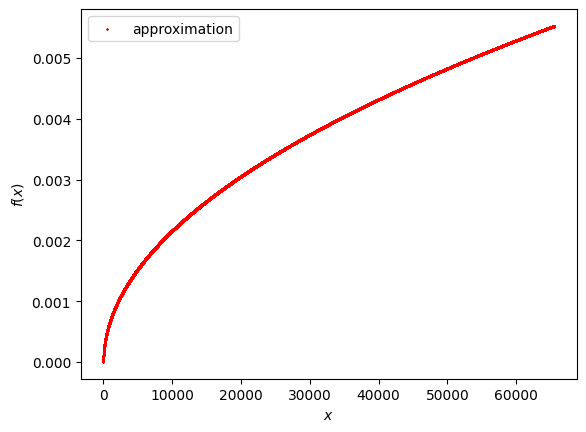

In [25]:
from qiskit import Aer, execute

final_state = execute(circ, Aer.get_backend('statevector_simulator')).result().get_statevector()

final_state = abs(np.array(final_state))

def reverse_bitstring_association(values):
    # Get the length of the list (n items require bitstrings of log2(n) bits)
    n = len(values)
    bit_length = len(bin(n - 1)) - 2  # Subtract 2 to remove the '0b' prefix from bin()

    # Create a new list to store rearranged values
    rearranged_values = [None] * n

    # Iterate over all the indices and reverse the bitstrings
    for i in range(n):
        # Convert index to binary string and pad with leading zeros
        bitstring = f"{i:0{bit_length}b}"
        
        # Reverse the bit string
        reversed_bitstring = bitstring[::-1]
        
        # Convert the reversed bit string back to an integer index
        reversed_index = int(reversed_bitstring, 2)
        
        # Place the value at the reversed index
        rearranged_values[reversed_index] = values[i]

    return rearranged_values

final_state = reverse_bitstring_association(final_state)

reshaped_vector = target_mps.to_dense()
plt.scatter(range(2**n), reshaped_vector, label = "approximation",marker='x',s=1,color='r')
#plt.scatter(range(2**n), final_state, label = "approximation",marker='x',s=1,color='b')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

In [11]:
overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=2,max_iterations=150)

doing variational optimization over sequential unitaries (num_var_seq_layers=6)...


100%|██████████| 6/6 [00:00<00:00,  9.08it/s]


number of variational params in the circuit (from sequential algorithm) are 1659
overlap before variational optimization = -0.9999943972


-0.999888181686 [best: -0.999995350838] : : 207it [19:31,  5.66s/it]                       


overllap after variational optimization = 0.9999953508377075 (from circ 0.9999989172301949),
n_gates=598, n_2qg=194



In [13]:
overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=16,max_iterations=150)

doing variational optimization over sequential unitaries (num_var_seq_layers=16)...


100%|██████████| 16/16 [00:01<00:00, 14.36it/s]


number of variational params in the circuit (from sequential algorithm) are 4395
overlap before variational optimization = -0.9999926686


-0.999849379063 [best: -0.999992728233] : : 178it [35:01, 11.81s/it]                       


overllap after variational optimization = 0.9999927282333374 (from circ 0.9999997622797853),
n_gates=1597, n_2qg=527



In [17]:
overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=48)

preparing mps using sequential unitaries (num_seq_layers=48)...


100%|██████████| 48/48 [00:04<00:00,  9.98it/s]


overlap from static seq. preparation = 0.9999999730284177 (from circ 0.9999999301407700),
n_gates=4294, n_2qg=1426



In [19]:
overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=200)

preparing mps using sequential unitaries (num_seq_layers=200)...


100%|██████████| 200/200 [00:55<00:00,  3.62it/s]


overlap from static seq. preparation = 0.9999999868768434 (from circ 0.9999999322759205),
n_gates=7165, n_2qg=2383



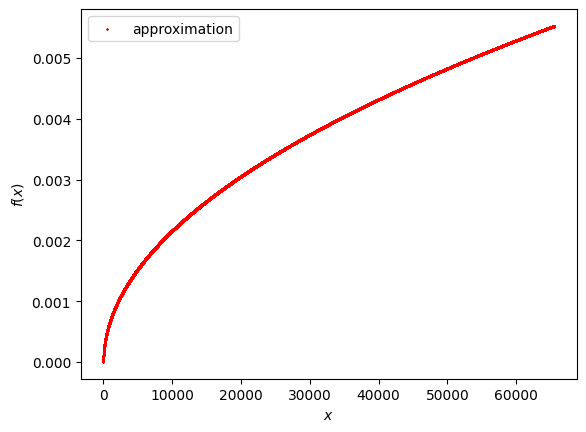

In [20]:
from qiskit import Aer, execute

final_state = execute(circ, Aer.get_backend('statevector_simulator')).result().get_statevector()

final_state = abs(np.array(final_state))

def reverse_bitstring_association(values):
    # Get the length of the list (n items require bitstrings of log2(n) bits)
    n = len(values)
    bit_length = len(bin(n - 1)) - 2  # Subtract 2 to remove the '0b' prefix from bin()

    # Create a new list to store rearranged values
    rearranged_values = [None] * n

    # Iterate over all the indices and reverse the bitstrings
    for i in range(n):
        # Convert index to binary string and pad with leading zeros
        bitstring = f"{i:0{bit_length}b}"
        
        # Reverse the bit string
        reversed_bitstring = bitstring[::-1]
        
        # Convert the reversed bit string back to an integer index
        reversed_index = int(reversed_bitstring, 2)
        
        # Place the value at the reversed index
        rearranged_values[reversed_index] = values[i]

    return rearranged_values

final_state = reverse_bitstring_association(final_state)

reshaped_vector = target_mps.to_dense()
plt.scatter(range(2**n), reshaped_vector, label = "exact",marker='x',s=1,color='r')
plt.scatter(range(2**n), final_state, label = "approximation",marker='x',s=1,color='b')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

In [63]:
from qiskit import Aer, execute

def plot_output(circ,target_mps,plot_exact=True):
    final_state = execute(circ, Aer.get_backend('statevector_simulator')).result().get_statevector()

    final_state = abs(np.array(final_state))

    def reverse_bitstring_association(values):
        # Get the length of the list (n items require bitstrings of log2(n) bits)
        n = len(values)
        bit_length = len(bin(n - 1)) - 2  # Subtract 2 to remove the '0b' prefix from bin()

        # Create a new list to store rearranged values
        rearranged_values = [None] * n

        # Iterate over all the indices and reverse the bitstrings
        for i in range(n):
            # Convert index to binary string and pad with leading zeros
            bitstring = f"{i:0{bit_length}b}"
            
            # Reverse the bit string
            reversed_bitstring = bitstring[::-1]
            
            # Convert the reversed bit string back to an integer index
            reversed_index = int(reversed_bitstring, 2)
            
            # Place the value at the reversed index
            rearranged_values[reversed_index] = values[i]

        return rearranged_values

    final_state = reverse_bitstring_association(final_state)

    if(plot_exact):
        reshaped_vector = target_mps.to_dense()
        plt.scatter(range(2**n), reshaped_vector, label = "exact",marker='x',s=1,color='r')
    plt.scatter(range(2**n), final_state, label = "approximation",marker='x',s=1,color='b')
    plt.legend()
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.show()

In [38]:
f = lambda x: x

n = 24

state_vector = np.array([f(x) for x in np.linspace(0,1,2**n)], dtype=complex)

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')   

In [39]:
overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=1)

preparing mps using sequential unitaries (num_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00, 10.90it/s]

overlap from static seq. preparation = 1.0000000000000000,
n_gates=138, n_2qg=38



In [40]:
f = lambda x: (
    2*x + 1 if 0 <= x < 0.2 else
    -x**2 + 3*x if 0.2 <= x < 0.4 else
    4 if 0.4 <= x < 0.6 else
    0.5*x**3 - x + 2 if 0.6 <= x < 0.8 else
    -2*x + 5 if 0.8 <= x <= 1 else
    None  # Returns None for inputs outside [0, 1]
)

n = 16

state_vector = np.array([f(x) for x in np.linspace(0,1,2**n)], dtype=complex)

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')   

In [46]:
overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=16)

preparing mps using sequential unitaries (num_seq_layers=16)...


100%|██████████| 16/16 [00:04<00:00,  3.79it/s]


overlap from static seq. preparation = 0.9982681968812583 (from circ 0.9982682890571866),
n_gates=1963, n_2qg=649



In [22]:
# SCALABILITY OF BOND DIMENSION 2 ENCODING

f = lambda x: np.where(np.abs(x) > 1e-6, np.sin(np.pi/x), 0)

sin_fidelities = []
sin_circs = []

n = 12
for layer in [12,18,24,30,36]:
    state_vector = np.array([f(x) for x in np.linspace(-1,1,2**n)], dtype=complex)

    target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
    target_mps_prep = MPSPreparation(target_mps,shape='lrp')  

    overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=layer)

    sin_fidelities.append(overlap)
    sin_circs.append(circ)
    

preparing mps using sequential unitaries (num_seq_layers=12)...


100%|██████████| 12/12 [00:00<00:00, 17.31it/s]


overlap from static seq. preparation = 0.9272348052398169 (from circ 0.9272351771413467),
n_gates=1098, n_2qg=362

preparing mps using sequential unitaries (num_seq_layers=18)...


100%|██████████| 18/18 [00:01<00:00, 14.52it/s]


overlap from static seq. preparation = 0.9427669549783321 (from circ 0.9427667779670552),
n_gates=1692, n_2qg=560

preparing mps using sequential unitaries (num_seq_layers=24)...


100%|██████████| 24/24 [00:01<00:00, 13.80it/s]


overlap from static seq. preparation = 0.9512623917641120 (from circ 0.9512624452499752),
n_gates=2286, n_2qg=758

preparing mps using sequential unitaries (num_seq_layers=30)...


100%|██████████| 30/30 [00:02<00:00, 10.91it/s]


overlap from static seq. preparation = 0.9567421753718022 (from circ 0.9567421049263001),
n_gates=2880, n_2qg=956

preparing mps using sequential unitaries (num_seq_layers=36)...


100%|██████████| 36/36 [00:03<00:00, 10.11it/s]


overlap from static seq. preparation = 0.9610671329088497 (from circ 0.9610671260676723),
n_gates=3474, n_2qg=1154



In [23]:
# SCALABILITY OF BOND DIMENSION 2 ENCODING

f = lambda x: np.where(np.abs(x) > 1e-6, np.sin(np.pi/x), 0)

sin_fidelities = []
sin_circs = []

n = 12
for layer in [12,18,24,30,36]:
    state_vector = np.array([f(x) for x in np.linspace(-1,1,2**n)], dtype=complex)

    target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
    target_mps_prep = MPSPreparation(target_mps,shape='lrp')  

    overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=layer,max_iterations=300)

    sin_fidelities.append(overlap)
    sin_circs.append(circ)
    

doing variational optimization over sequential unitaries (num_var_seq_layers=12)...


100%|██████████| 12/12 [00:00<00:00, 17.14it/s]


number of variational params in the circuit (from sequential algorithm) are 3000
overlap before variational optimization = -0.9272301793


-0.965564012527 [best: -0.971424996853] : : 627it [1:21:26,  7.79s/it]                     


overllap after variational optimization = 0.9714249968528748 (from circ 0.9714295353633445),
n_gates=1098, n_2qg=362

doing variational optimization over sequential unitaries (num_var_seq_layers=18)...


100%|██████████| 18/18 [00:01<00:00, 13.46it/s]


number of variational params in the circuit (from sequential algorithm) are 4602
overlap before variational optimization = -0.9427610040


-0.973151743412 [best: -0.976750433445] : : 625it [2:03:48, 11.89s/it]                     


overllap after variational optimization = 0.9767504334449768 (from circ 0.9767585122231881),
n_gates=1692, n_2qg=560

doing variational optimization over sequential unitaries (num_var_seq_layers=24)...


100%|██████████| 24/24 [00:01<00:00, 12.90it/s]


number of variational params in the circuit (from sequential algorithm) are 6204
overlap before variational optimization = -0.9512561560


-0.977692663670 [best: -0.980784595013] : : 624it [2:48:13, 16.17s/it]                       


overllap after variational optimization = 0.9807845950126648 (from circ 0.9807978843647037),
n_gates=2286, n_2qg=758

doing variational optimization over sequential unitaries (num_var_seq_layers=30)...


100%|██████████| 30/30 [00:02<00:00, 10.33it/s]


number of variational params in the circuit (from sequential algorithm) are 7806
overlap before variational optimization = -0.9567315578


-0.983042180538 [best: -0.984725713730] : : 630it [4:04:04, 23.24s/it]                       


overllap after variational optimization = 0.9847257137298584 (from circ 0.9847396269506073),
n_gates=2880, n_2qg=956

doing variational optimization over sequential unitaries (num_var_seq_layers=36)...


100%|██████████| 36/36 [00:06<00:00,  5.44it/s]


number of variational params in the circuit (from sequential algorithm) are 9408
overlap before variational optimization = -0.9610573649


-0.985044836998 [best: -0.986755728722] : : 624it [5:34:37, 32.18s/it]                         


overllap after variational optimization = 0.9867557287216187 (from circ 0.9867762412339104),
n_gates=3474, n_2qg=1154



In [16]:
# SCALABILITY OF BOND DIMENSION 2 ENCODING

f = lambda x: x

linear_fidelities = []
linear_circs = []
for i in [30,32]:
    n = i

    state_vector = np.array([f(x) for x in np.linspace(0,1,2**n)], dtype=complex)

    target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
    target_mps_prep = MPSPreparation(target_mps,shape='lrp')  

    overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=1)

    linear_fidelities.append(overlap)
    linear_circs.append(circ)

KeyboardInterrupt: 

In [78]:
print(linear_circs[2].draw())

global phase: 5.2038
       ┌──────────────────┐ ┌───┐┌──────────────────────────┐┌───┐»
q_0: ──┤ U3(3.0991,π/2,0) ├─┤ X ├┤ U3(1.6036,-3.029,1.6075) ├┤ X ├»
     ┌─┴──────────────────┴┐└─┬─┘└──┬───────────────────┬───┘└─┬─┘»
q_1: ┤ U3(π/2,2.7909,-π/2) ├──■─────┤ U3(1.6822,0,-π/2) ├──────■──»
     └┬───────────────────┬┘        └───────────────────┘         »
q_2: ─┤ U3(0.67715,π/2,0) ├───────────────────────────────────────»
      ├───────────────────┴┐                                      »
q_3: ─┤ U3(0.77127,-π/2,0) ├──────────────────────────────────────»
      ├────────────────────┤                                      »
q_4: ─┤ U3(0.23655,π/2,-π) ├──────────────────────────────────────»
      ├───────────────────┬┘                                      »
q_5: ─┤ U3(2.9125,-π/2,0) ├───────────────────────────────────────»
      └───────────────────┘                                       »
«        ┌──────────────────┐                                          »
«q_0: ───┤ U3(2.8278,0

In [81]:
#LAYERS FOR NP.SQRT(X)

f = lambda x: np.sqrt(x)

root_circs = []
root_fidelities = []

n = 24

state_vector = np.array([f(x) for x in np.linspace(0,1,2**n)], dtype=complex)

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')  

for L in range(1,65,2):
    overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=L)

    root_fidelities.append(overlap)
    root_circs.append(circ)

preparing mps using sequential unitaries (num_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00, 12.60it/s]

overlap from static seq. preparation = 0.9999900971121737,
n_gates=141, n_2qg=39

preparing mps using sequential unitaries (num_seq_layers=3)...



100%|██████████| 3/3 [00:00<00:00, 13.08it/s]


overlap from static seq. preparation = 0.9999954135445058,
n_gates=324, n_2qg=100

preparing mps using sequential unitaries (num_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00, 13.83it/s]


overlap from static seq. preparation = 0.9999986964605416,
n_gates=483, n_2qg=153

preparing mps using sequential unitaries (num_seq_layers=7)...


100%|██████████| 7/7 [00:00<00:00, 11.83it/s]


overlap from static seq. preparation = 0.9999991602351461,
n_gates=675, n_2qg=217

preparing mps using sequential unitaries (num_seq_layers=9)...


100%|██████████| 9/9 [00:00<00:00, 12.26it/s]


overlap from static seq. preparation = 0.9999994445303511,
n_gates=822, n_2qg=266

preparing mps using sequential unitaries (num_seq_layers=11)...


100%|██████████| 11/11 [00:00<00:00, 11.03it/s]


overlap from static seq. preparation = 0.9999995982090931,
n_gates=996, n_2qg=324

preparing mps using sequential unitaries (num_seq_layers=13)...


100%|██████████| 13/13 [00:01<00:00, 11.38it/s]


overlap from static seq. preparation = 0.9999996834287497,
n_gates=1224, n_2qg=400

preparing mps using sequential unitaries (num_seq_layers=15)...


100%|██████████| 15/15 [00:01<00:00, 10.34it/s]


overlap from static seq. preparation = 0.9999997984650213,
n_gates=1383, n_2qg=453

preparing mps using sequential unitaries (num_seq_layers=17)...


100%|██████████| 17/17 [00:01<00:00, 10.60it/s]


overlap from static seq. preparation = 0.9999998401465625,
n_gates=1587, n_2qg=521

preparing mps using sequential unitaries (num_seq_layers=19)...


100%|██████████| 19/19 [00:01<00:00,  9.69it/s]


overlap from static seq. preparation = 0.9999998415778208,
n_gates=1797, n_2qg=591

preparing mps using sequential unitaries (num_seq_layers=21)...


100%|██████████| 21/21 [00:02<00:00,  9.85it/s]


overlap from static seq. preparation = 0.9999998812575452,
n_gates=1965, n_2qg=647

preparing mps using sequential unitaries (num_seq_layers=23)...


100%|██████████| 23/23 [00:02<00:00,  8.82it/s]


overlap from static seq. preparation = 0.9999998855330686,
n_gates=2184, n_2qg=720

preparing mps using sequential unitaries (num_seq_layers=25)...


100%|██████████| 25/25 [00:02<00:00,  9.15it/s]


overlap from static seq. preparation = 0.9999999028638644,
n_gates=2358, n_2qg=778

preparing mps using sequential unitaries (num_seq_layers=27)...


100%|██████████| 27/27 [00:03<00:00,  8.03it/s]


overlap from static seq. preparation = 0.9999999108726130,
n_gates=2520, n_2qg=832

preparing mps using sequential unitaries (num_seq_layers=29)...


100%|██████████| 29/29 [00:03<00:00,  8.33it/s]


overlap from static seq. preparation = 0.9999999269794617,
n_gates=2694, n_2qg=890

preparing mps using sequential unitaries (num_seq_layers=31)...


100%|██████████| 31/31 [00:04<00:00,  7.70it/s]


overlap from static seq. preparation = 0.9999999402922758,
n_gates=2880, n_2qg=952

preparing mps using sequential unitaries (num_seq_layers=33)...


100%|██████████| 33/33 [00:04<00:00,  8.14it/s]


overlap from static seq. preparation = 0.9999999428942621,
n_gates=3030, n_2qg=1002

preparing mps using sequential unitaries (num_seq_layers=35)...


100%|██████████| 35/35 [00:04<00:00,  7.52it/s]


overlap from static seq. preparation = 0.9999999461148691,
n_gates=3231, n_2qg=1069

preparing mps using sequential unitaries (num_seq_layers=37)...


100%|██████████| 37/37 [00:04<00:00,  7.74it/s]


overlap from static seq. preparation = 0.9999999549323497,
n_gates=3399, n_2qg=1125

preparing mps using sequential unitaries (num_seq_layers=39)...


100%|██████████| 39/39 [00:05<00:00,  6.98it/s]


overlap from static seq. preparation = 0.9999999609105618,
n_gates=3564, n_2qg=1180

preparing mps using sequential unitaries (num_seq_layers=41)...


100%|██████████| 41/41 [00:05<00:00,  7.23it/s]


overlap from static seq. preparation = 0.9999999624653627,
n_gates=3744, n_2qg=1240

preparing mps using sequential unitaries (num_seq_layers=43)...


100%|██████████| 43/43 [00:06<00:00,  6.74it/s]


overlap from static seq. preparation = 0.9999999623037916,
n_gates=3918, n_2qg=1298

preparing mps using sequential unitaries (num_seq_layers=45)...


100%|██████████| 45/45 [00:06<00:00,  6.93it/s]


overlap from static seq. preparation = 0.9999999663781948,
n_gates=4086, n_2qg=1354

preparing mps using sequential unitaries (num_seq_layers=47)...


100%|██████████| 47/47 [00:07<00:00,  6.46it/s]


overlap from static seq. preparation = 0.9999999686672006,
n_gates=4239, n_2qg=1405

preparing mps using sequential unitaries (num_seq_layers=49)...


100%|██████████| 49/49 [00:07<00:00,  6.64it/s]


overlap from static seq. preparation = 0.9999999741025902,
n_gates=4371, n_2qg=1449

preparing mps using sequential unitaries (num_seq_layers=51)...


100%|██████████| 51/51 [00:08<00:00,  6.14it/s]


overlap from static seq. preparation = 0.9999999751158521,
n_gates=4515, n_2qg=1497

preparing mps using sequential unitaries (num_seq_layers=53)...


100%|██████████| 53/53 [00:08<00:00,  6.35it/s]


overlap from static seq. preparation = 0.9999999770233798,
n_gates=4698, n_2qg=1558

preparing mps using sequential unitaries (num_seq_layers=55)...


100%|██████████| 55/55 [00:09<00:00,  5.99it/s]


overlap from static seq. preparation = 0.9999999777312475,
n_gates=4866, n_2qg=1614

preparing mps using sequential unitaries (num_seq_layers=57)...


100%|██████████| 57/57 [00:09<00:00,  6.05it/s]


overlap from static seq. preparation = 0.9999999797399856,
n_gates=5004, n_2qg=1660

preparing mps using sequential unitaries (num_seq_layers=59)...


100%|██████████| 59/59 [00:10<00:00,  5.69it/s]


overlap from static seq. preparation = 0.9999999820410977,
n_gates=5124, n_2qg=1700

preparing mps using sequential unitaries (num_seq_layers=61)...


100%|██████████| 61/61 [00:10<00:00,  5.77it/s]


overlap from static seq. preparation = 0.9999999819219583,
n_gates=5298, n_2qg=1758

preparing mps using sequential unitaries (num_seq_layers=63)...


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


overlap from static seq. preparation = 0.9999999821900361,
n_gates=5478, n_2qg=1818



In [82]:
for i in root_circs:
    print(i.depth())

79
105
125
145
175
201
221
251
273
291
321
341
365
387
417
441
465
489
511
539
559
577
611
631
655
679
705
731
751
779
801
823


In [ ]:
# SCALABILITY OF BOND DIMENSION 2 ENCODING

f = lambda x: x

#linear_fidelities = []
#linear_circs = []

n = 30

state_vector = np.array([f(x) for x in np.linspace(0,1,2**n)], dtype=np.float)

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')  

overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=1)

linear_fidelities.append(overlap)
linear_circs.append(circ)


n = 32

state_vector = np.array([f(x) for x in np.linspace(0,1,2**n)], dtype=np.float)

target_mps = qtn.MatrixProductState.from_dense(state_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')  

overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=1)

linear_fidelities.append(overlap)
linear_circs.append(circ)


In [3]:
#BOND DIMENSION OF 3 (8 QUBITS HIGHER LAYERS)

#8 QUBITS.


fid_ran3 = []
n_ran3 = []
n2_ran3 = []

fid_opt3 = []
n_opt3 = []
n2_opt3 = []

circs3 = []

target_mps3 = qtn.MPS_rand_state(L=8, bond_dim=3)

for layers in range(1,21,2):
    for i in range(1):
        target_mps_prep3 = MPSPreparation(target_mps3,shape='lrp')   

        overlap, circ = target_mps_prep3.sequential_unitary_circuit(num_seq_layers=layers)

        fid_ran3.append(overlap)
        n_ran3.append(circ.size())
        n2_ran3.append(circ.num_nonlocal_gates())

        overlap, circ = target_mps_prep3.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=300)

        fid_opt3.append(overlap)
        circs3.append(circ)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran3[-1:]))
    print(list(fid_opt3[-1:]))
    print(list(n_ran3[-1:]))
    print(list(n2_ran3[-1:]))

print(fid_ran3)
print(fid_opt3)
print(n_ran3)
print(n2_ran3)

preparing mps using sequential unitaries (num_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


overlap from static seq. preparation = 0.9808372250557958 (from circ 0.9808372250557955),
n_gates=59, n_2qg=17

doing variational optimization over sequential unitaries (num_var_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00, 38.67it/s]
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


number of variational params in the circuit (from sequential algorithm) are 153
overlap before variational optimization = -0.9808369875


-0.980839312077 [best: -0.980842471123] :  47%|████▋     | 142/300 [01:04<01:12,  2.19it/s]


overllap after variational optimization = 0.9808424711227417 (from circ 0.9808426178088386),
n_gates=62, n_2qg=18

Layer = 1 done:
[0.9808372250557958]
[0.9808424711227417]
[59]
[17]
preparing mps using sequential unitaries (num_seq_layers=3)...


100%|██████████| 3/3 [00:00<00:00, 34.72it/s]

overlap from static seq. preparation = 0.9918651954519624 (from circ 0.9918651954519622),
n_gates=155, n_2qg=49

doing variational optimization over sequential unitaries (num_var_seq_layers=3)...



100%|██████████| 3/3 [00:00<00:00, 32.78it/s]


number of variational params in the circuit (from sequential algorithm) are 426
overlap before variational optimization = -0.9918643236


-0.998761475086 [best: -0.998761475086] : : 632it [11:22,  1.08s/it]                       


overllap after variational optimization = 0.9987614750862122 (from circ 0.9987620538745078),
n_gates=155, n_2qg=49

Layer = 3 done:
[0.9918651954519624]
[0.9987614750862122]
[155]
[49]
preparing mps using sequential unitaries (num_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00, 48.79it/s]


overlap from static seq. preparation = 0.9929976366927199 (from circ 0.9929976366927191),
n_gates=263, n_2qg=85

doing variational optimization over sequential unitaries (num_var_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00, 49.56it/s]


number of variational params in the circuit (from sequential algorithm) are 744
overlap before variational optimization = -0.9929959178


-0.999557316303 [best: -0.999689757824] : : 620it [19:08,  1.85s/it]                       


overllap after variational optimization = 0.9996897578239441 (from circ 0.9996917608242684),
n_gates=269, n_2qg=87

Layer = 5 done:
[0.9929976366927199]
[0.9996897578239441]
[263]
[85]
preparing mps using sequential unitaries (num_seq_layers=7)...


100%|██████████| 7/7 [00:00<00:00, 40.60it/s]


overlap from static seq. preparation = 0.9968214014765041 (from circ 0.9968213950143047),
n_gates=353, n_2qg=115

doing variational optimization over sequential unitaries (num_var_seq_layers=7)...


100%|██████████| 7/7 [00:00<00:00, 40.57it/s]


number of variational params in the circuit (from sequential algorithm) are 1014
overlap before variational optimization = -0.9969994426


-0.999759912491 [best: -0.999869883060] : : 606it [25:31,  2.53s/it]                       


overllap after variational optimization = 0.9998698830604553 (from circ 0.9998709470379775),
n_gates=359, n_2qg=117

Layer = 7 done:
[0.9968214014765041]
[0.9998698830604553]
[353]
[115]
preparing mps using sequential unitaries (num_seq_layers=9)...


100%|██████████| 9/9 [00:00<00:00, 41.74it/s]


overlap from static seq. preparation = 0.9958648487265711 (from circ 0.9958648487258981),
n_gates=530, n_2qg=174

doing variational optimization over sequential unitaries (num_var_seq_layers=9)...


100%|██████████| 9/9 [00:00<00:00, 43.43it/s]


number of variational params in the circuit (from sequential algorithm) are 1362


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.p

overlap before variational optimization = -0.9972664714


-0.999947130680 [best: -0.999947130680] : : 455it [25:47,  3.40s/it]                       


overllap after variational optimization = 0.9999471306800842 (from circ 0.9999489528223695),
n_gates=488, n_2qg=160

Layer = 9 done:
[0.9958648487265711]
[0.9999471306800842]
[530]
[174]
preparing mps using sequential unitaries (num_seq_layers=11)...


100%|██████████| 11/11 [00:00<00:00, 37.88it/s]


overlap from static seq. preparation = 0.9980848454655884 (from circ 0.9980848454655841),
n_gates=647, n_2qg=213

doing variational optimization over sequential unitaries (num_var_seq_layers=11)...


100%|██████████| 11/11 [00:00<00:00, 36.05it/s]


number of variational params in the circuit (from sequential algorithm) are 1647
overlap before variational optimization = -0.9973507524


-0.999970614910 [best: -0.999970614910] : : 491it [35:02,  4.28s/it]                       


overllap after variational optimization = 0.9999706149101257 (from circ 0.9999726558606546),
n_gates=587, n_2qg=193

Layer = 11 done:
[(0.9980848454655884+2.1027485004945787e-09j)]
[0.9999706149101257]
[647]
[213]
preparing mps using sequential unitaries (num_seq_layers=13)...


100%|██████████| 13/13 [00:00<00:00, 39.19it/s]


overlap from static seq. preparation = 0.9988766657103049 (from circ 0.9988766634192705),
n_gates=752, n_2qg=248

doing variational optimization over sequential unitaries (num_var_seq_layers=13)...


100%|██████████| 13/13 [00:00<00:00, 39.73it/s]


number of variational params in the circuit (from sequential algorithm) are 1953
overlap before variational optimization = -0.9988012910


-0.999987781048 [best: -0.999987781048] : : 364it [29:28,  4.86s/it]                       


overllap after variational optimization = 0.9999877810478210 (from circ 0.9999904299345046),
n_gates=695, n_2qg=229

Layer = 13 done:
[(0.9988766657103049+5.6124749348886105e-09j)]
[0.999987781047821]
[752]
[248]
preparing mps using sequential unitaries (num_seq_layers=15)...


100%|██████████| 15/15 [00:00<00:00, 35.77it/s]


overlap from static seq. preparation = 0.9988362378114843 (from circ 0.9988362378124058),
n_gates=869, n_2qg=287

doing variational optimization over sequential unitaries (num_var_seq_layers=15)...


100%|██████████| 15/15 [00:00<00:00, 35.67it/s]


number of variational params in the circuit (from sequential algorithm) are 2406
overlap before variational optimization = -0.9983369708


-0.999991118908 [best: -0.999991118908] :  72%|███████▏  | 215/300 [21:19<08:25,  5.95s/it]


overllap after variational optimization = 0.9999911189079285 (from circ 0.9999947626024571),
n_gates=875, n_2qg=289

Layer = 15 done:
[(0.9988362378114843-4.915026484766936e-10j)]
[0.9999911189079285]
[869]
[287]
preparing mps using sequential unitaries (num_seq_layers=17)...


100%|██████████| 17/17 [00:00<00:00, 36.66it/s]


overlap from static seq. preparation = 0.9989316649943041 (from circ 0.9989316649935951),
n_gates=989, n_2qg=327

doing variational optimization over sequential unitaries (num_var_seq_layers=17)...


100%|██████████| 17/17 [00:00<00:00, 36.92it/s]


number of variational params in the circuit (from sequential algorithm) are 2613
overlap before variational optimization = -0.9990901947


-0.999994695187 [best: -0.999994695187] : : 339it [36:28,  6.46s/it]                       


overllap after variational optimization = 0.9999946951866150 (from circ 0.9999983791849539),
n_gates=932, n_2qg=308

Layer = 17 done:
[(0.9989316649943041+3.949991957434213e-09j)]
[0.999994695186615]
[989]
[327]
preparing mps using sequential unitaries (num_seq_layers=19)...


100%|██████████| 19/19 [00:00<00:00, 32.77it/s]


overlap from static seq. preparation = 0.9992373727795302 (from circ 0.9992373727746753),
n_gates=1112, n_2qg=368

doing variational optimization over sequential unitaries (num_var_seq_layers=19)...


100%|██████████| 19/19 [00:00<00:00, 32.53it/s]


number of variational params in the circuit (from sequential algorithm) are 2934
overlap before variational optimization = -0.9994110465


-0.999992549419 [best: -0.999992549419] :  55%|█████▌    | 166/300 [20:16<16:21,  7.33s/it]


overllap after variational optimization = 0.9999925494194031 (from circ 0.9999973949398078),
n_gates=1052, n_2qg=348

Layer = 19 done:
[0.9992373727795302]
[0.9999925494194031]
[1112]
[368]
[0.9808372250557958, 0.9918651954519624, 0.9929976366927199, 0.9968214014765041, 0.9958648487265711, (0.9980848454655884+2.1027485004945787e-09j), (0.9988766657103049+5.6124749348886105e-09j), (0.9988362378114843-4.915026484766936e-10j), (0.9989316649943041+3.949991957434213e-09j), 0.9992373727795302]
[0.9808424711227417, 0.9987614750862122, 0.9996897578239441, 0.9998698830604553, 0.9999471306800842, 0.9999706149101257, 0.999987781047821, 0.9999911189079285, 0.999994695186615, 0.9999925494194031]
[59, 155, 263, 353, 530, 647, 752, 869, 989, 1112]
[17, 49, 85, 115, 174, 213, 248, 287, 327, 368]


In [4]:
#BOND DIMENSION OF 4 (8 QUBITS HIGHER LAYERS)

#8 QUBITS.

fid_ran4 = []
n_ran4 = []
n2_ran4 = []

fid_opt4 = []
n_opt4 = []
n2_opt4 = []

circs4 = []

target_mps4 = qtn.MPS_rand_state(L=8, bond_dim=4)

for layers in range(1,21,2):
    for i in range(1):
        target_mps_prep4 = MPSPreparation(target_mps4,shape='lrp')   

        overlap, circ = target_mps_prep4.sequential_unitary_circuit(num_seq_layers=layers)

        fid_ran4.append(overlap)
        n_ran4.append(circ.size())
        n2_ran4.append(circ.num_nonlocal_gates())

        overlap, circ = target_mps_prep4.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=300)
        circs4.append(circ)
        fid_opt4.append(overlap)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran4[-1:]))
    print(list(fid_opt4[-1:]))
    print(list(n_ran4[-1:]))
    print(list(n2_ran4[-1:]))

print(fid_ran4)
print(fid_opt4)
print(n_ran4)
print(n2_ran4)

preparing mps using sequential unitaries (num_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00, 34.15it/s]


overlap from static seq. preparation = 0.7688885033856827 (from circ 0.7688885033856827),
n_gates=56, n_2qg=16

doing variational optimization over sequential unitaries (num_var_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00, 42.50it/s]

number of variational params in the circuit (from sequential algorithm) are 141


overlap before variational optimization = -0.7688882351


-0.783124744892 [best: -0.783129513264] :  58%|█████▊    | 173/300 [01:00<00:44,  2.85it/s]


overllap after variational optimization = 0.7831295132637024 (from circ 0.7831293762511754),
n_gates=56, n_2qg=16

Layer = 1 done:
[0.7688885033856827]
[0.7831295132637024]
[56]
[16]
preparing mps using sequential unitaries (num_seq_layers=3)...


100%|██████████| 3/3 [00:00<00:00, 42.09it/s]


overlap from static seq. preparation = 0.8670256252217856 (from circ 0.8670256252217854),
n_gates=164, n_2qg=52

doing variational optimization over sequential unitaries (num_var_seq_layers=3)...


100%|██████████| 3/3 [00:00<00:00, 43.57it/s]


number of variational params in the circuit (from sequential algorithm) are 450
overlap before variational optimization = -0.8670248985


-0.987792193890 [best: -0.987792193890] : : 628it [11:45,  1.12s/it]                       


overllap after variational optimization = 0.9877921938896179 (from circ 0.9877924612426309),
n_gates=167, n_2qg=53

Layer = 3 done:
[0.8670256252217856]
[0.9877921938896179]
[164]
[52]
preparing mps using sequential unitaries (num_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00, 45.28it/s]


overlap from static seq. preparation = 0.9229001748073542 (from circ 0.9229001748073533),
n_gates=266, n_2qg=86

doing variational optimization over sequential unitaries (num_var_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00, 46.96it/s]


number of variational params in the circuit (from sequential algorithm) are 789
overlap before variational optimization = -0.9197856188


-0.998814284801 [best: -0.998814284801] : : 628it [20:33,  1.96s/it]                       


overllap after variational optimization = 0.9988142848014832 (from circ 0.9988154455882563),
n_gates=290, n_2qg=94

Layer = 5 done:
[0.9229001748073542]
[0.9988142848014832]
[266]
[86]
preparing mps using sequential unitaries (num_seq_layers=7)...


100%|██████████| 7/7 [00:00<00:00, 40.48it/s]


overlap from static seq. preparation = 0.9317579407057975 (from circ 0.9317579407057903),
n_gates=392, n_2qg=128

doing variational optimization over sequential unitaries (num_var_seq_layers=7)...


100%|██████████| 7/7 [00:00<00:00, 40.22it/s]


number of variational params in the circuit (from sequential algorithm) are 1044
overlap before variational optimization = -0.9304786921


-0.999186456203 [best: -0.999186456203] : : 617it [27:14,  2.65s/it]                       


overllap after variational optimization = 0.9991864562034607 (from circ 0.9991881770970859),
n_gates=374, n_2qg=122

Layer = 7 done:
[0.9317579407057975]
[0.9991864562034607]
[392]
[128]
preparing mps using sequential unitaries (num_seq_layers=9)...


100%|██████████| 9/9 [00:00<00:00, 44.16it/s]


overlap from static seq. preparation = 0.9575465626109423 (from circ 0.9575465626109410),
n_gates=482, n_2qg=158

doing variational optimization over sequential unitaries (num_var_seq_layers=9)...


100%|██████████| 9/9 [00:00<00:00, 42.96it/s]


number of variational params in the circuit (from sequential algorithm) are 1371
overlap before variational optimization = -0.9563095570


-0.999544382095 [best: -0.999544382095] : : 626it [35:53,  3.44s/it]                       


overllap after variational optimization = 0.9995443820953369 (from circ 0.9995471013388866),
n_gates=494, n_2qg=162

Layer = 9 done:
[0.9575465626109423]
[0.9995443820953369]
[482]
[158]
preparing mps using sequential unitaries (num_seq_layers=11)...


100%|██████████| 11/11 [00:00<00:00, 36.14it/s]


overlap from static seq. preparation = 0.9593093099022674 (from circ 0.9593093099032330),
n_gates=668, n_2qg=220

doing variational optimization over sequential unitaries (num_var_seq_layers=11)...


100%|██████████| 11/11 [00:00<00:00, 37.62it/s]


number of variational params in the circuit (from sequential algorithm) are 1782
overlap before variational optimization = -0.9586564302


-0.999966382980 [best: -0.999966382980] : : 579it [43:12,  4.48s/it]                       


overllap after variational optimization = 0.9999663829803467 (from circ 0.9999689795804242),
n_gates=653, n_2qg=215

Layer = 11 done:
[0.9593093099022674]
[0.9999663829803467]
[668]
[220]
preparing mps using sequential unitaries (num_seq_layers=13)...


100%|██████████| 13/13 [00:00<00:00, 39.73it/s]


overlap from static seq. preparation = 0.9690066111098594 (from circ 0.9690066111098548),
n_gates=782, n_2qg=258

doing variational optimization over sequential unitaries (num_var_seq_layers=13)...


100%|██████████| 13/13 [00:00<00:00, 39.81it/s]


number of variational params in the circuit (from sequential algorithm) are 2118


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.p

overlap before variational optimization = -0.9706203341


-0.999986708164 [best: -0.999986708164] : : 370it [32:57,  5.34s/it]                       


overllap after variational optimization = 0.9999867081642151 (from circ 0.9999902954152836),
n_gates=776, n_2qg=256

Layer = 13 done:
[0.9690066111098594]
[0.9999867081642151]
[782]
[258]
preparing mps using sequential unitaries (num_seq_layers=15)...


100%|██████████| 15/15 [00:00<00:00, 33.39it/s]


overlap from static seq. preparation = 0.9743775188351569 (from circ 0.9743775188354393),
n_gates=869, n_2qg=287

doing variational optimization over sequential unitaries (num_var_seq_layers=15)...


100%|██████████| 15/15 [00:00<00:00, 33.83it/s]


number of variational params in the circuit (from sequential algorithm) are 2451
overlap before variational optimization = -0.9726832509


-0.999991178513 [best: -0.999991178513] :  96%|█████████▌| 287/300 [29:18<01:19,  6.13s/it]


overllap after variational optimization = 0.9999911785125732 (from circ 0.9999951206511708),
n_gates=899, n_2qg=297

Layer = 15 done:
[0.9743775188351569]
[0.9999911785125732]
[869]
[287]
preparing mps using sequential unitaries (num_seq_layers=17)...


100%|██████████| 17/17 [00:00<00:00, 36.60it/s]


overlap from static seq. preparation = 0.9783933655286738 (from circ 0.9783933655286696),
n_gates=1046, n_2qg=346

doing variational optimization over sequential unitaries (num_var_seq_layers=17)...


100%|██████████| 17/17 [00:00<00:00, 36.26it/s]


number of variational params in the circuit (from sequential algorithm) are 2781
overlap before variational optimization = -0.9816269279


-0.999993503094 [best: -0.999993503094] :  88%|████████▊ | 264/300 [30:44<04:11,  6.98s/it]


overllap after variational optimization = 0.9999935030937195 (from circ 0.9999977689947714),
n_gates=1019, n_2qg=337

Layer = 17 done:
[0.9783933655286738]
[0.9999935030937195]
[1046]
[346]
preparing mps using sequential unitaries (num_seq_layers=19)...


100%|██████████| 19/19 [00:00<00:00, 32.35it/s]


overlap from static seq. preparation = 0.9823097147044975 (from circ 0.9823097147015601),
n_gates=1088, n_2qg=360

doing variational optimization over sequential unitaries (num_var_seq_layers=19)...


100%|██████████| 19/19 [00:00<00:00, 32.82it/s]


number of variational params in the circuit (from sequential algorithm) are 3132
overlap before variational optimization = -0.9829167724


-0.999992549419 [best: -0.999992549419] :  89%|████████▊ | 266/300 [36:39<04:41,  8.27s/it]


overllap after variational optimization = 0.9999925494194031 (from circ 0.9999979105202956),
n_gates=1148, n_2qg=380

Layer = 19 done:
[0.9823097147044975]
[0.9999925494194031]
[1088]
[360]
[0.7688885033856827, 0.8670256252217856, 0.9229001748073542, 0.9317579407057975, 0.9575465626109423, 0.9593093099022674, 0.9690066111098594, 0.9743775188351569, 0.9783933655286738, 0.9823097147044975]
[0.7831295132637024, 0.9877921938896179, 0.9988142848014832, 0.9991864562034607, 0.9995443820953369, 0.9999663829803467, 0.9999867081642151, 0.9999911785125732, 0.9999935030937195, 0.9999925494194031]
[56, 164, 266, 392, 482, 668, 782, 869, 1046, 1088]
[16, 52, 86, 128, 158, 220, 258, 287, 346, 360]


In [5]:
#BOND DIMENSION OF 5 (8 QUBITS HIGHER LAYERS)

#8 QUBITS.

fid_ran5 = []
n_ran5 = []
n2_ran5 = []

fid_opt5 = []
n_opt5 = []
n2_opt5 = []

circs5 = []

target_mps5 = qtn.MPS_rand_state(L=8, bond_dim=5)

for layers in range(1,21,2):
    for i in range(1):
        target_mps_prep5 = MPSPreparation(target_mps5,shape='lrp')   

        overlap, circ = target_mps_prep5.sequential_unitary_circuit(num_seq_layers=layers)

        fid_ran5.append(overlap)
        n_ran5.append(circ.size())
        n2_ran5.append(circ.num_nonlocal_gates())

        overlap, circ = target_mps_prep5.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=300)
        circs5.append(circ)
        fid_opt5.append(overlap)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran5[-1:]))
    print(list(fid_opt5[-1:]))
    print(list(n_ran5[-1:]))
    print(list(n2_ran5[-1:]))

print(fid_ran5)
print(fid_opt5)
print(n_ran5)
print(n2_ran5)

preparing mps using sequential unitaries (num_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00, 25.78it/s]


overlap from static seq. preparation = 0.8723535565495255 (from circ 0.8723535565495258),
n_gates=59, n_2qg=17

doing variational optimization over sequential unitaries (num_var_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00, 30.77it/s]


number of variational params in the circuit (from sequential algorithm) are 147
overlap before variational optimization = -0.8723531961


-0.874021649361 [best: -0.874024152756] :  50%|████▉     | 149/300 [00:59<01:00,  2.49it/s]


overllap after variational optimization = 0.8740241527557373 (from circ 0.8740239883922447),
n_gates=59, n_2qg=17

Layer = 1 done:
[0.8723535565495255]
[0.8740241527557373]
[59]
[17]
preparing mps using sequential unitaries (num_seq_layers=3)...


100%|██████████| 3/3 [00:00<00:00, 30.23it/s]

overlap from static seq. preparation = 0.9324789899715503 (from circ 0.9324789899715493),
n_gates=167, n_2qg=53

doing variational optimization over sequential unitaries (num_var_seq_layers=3)...



100%|██████████| 3/3 [00:00<00:00, 31.56it/s]


number of variational params in the circuit (from sequential algorithm) are 423
overlap before variational optimization = -0.9324782491


-0.991773307323 [best: -0.992855310440] : : 624it [12:06,  1.16s/it]                       


overllap after variational optimization = 0.9928553104400635 (from circ 0.9928564699263948),
n_gates=152, n_2qg=48

Layer = 3 done:
[0.9324789899715503]
[0.9928553104400635]
[167]
[53]
preparing mps using sequential unitaries (num_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00, 38.02it/s]


overlap from static seq. preparation = 0.9493164272550743 (from circ 0.9493164272550728),
n_gates=260, n_2qg=84

doing variational optimization over sequential unitaries (num_var_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00, 39.28it/s]


number of variational params in the circuit (from sequential algorithm) are 735
overlap before variational optimization = -0.9473325610


-0.998005151749 [best: -0.998005151749] : : 619it [19:41,  1.91s/it]                       


overllap after variational optimization = 0.9980051517486572 (from circ 0.9980062201437204),
n_gates=266, n_2qg=86

Layer = 5 done:
[0.9493164272550743]
[0.9980051517486572]
[260]
[84]
preparing mps using sequential unitaries (num_seq_layers=7)...


100%|██████████| 7/7 [00:00<00:00, 35.15it/s]


overlap from static seq. preparation = 0.9625858278341962 (from circ 0.9625858278341944),
n_gates=374, n_2qg=122

doing variational optimization over sequential unitaries (num_var_seq_layers=7)...


100%|██████████| 7/7 [00:00<00:00, 35.02it/s]


number of variational params in the circuit (from sequential algorithm) are 1020
overlap before variational optimization = -0.9617370367


-0.999280571938 [best: -0.999280571938] : : 626it [27:28,  2.63s/it]                       


overllap after variational optimization = 0.9992805719375610 (from circ 0.9992822897776824),
n_gates=362, n_2qg=118

Layer = 7 done:
[0.9625858278341962]
[0.999280571937561]
[374]
[122]
preparing mps using sequential unitaries (num_seq_layers=9)...


100%|██████████| 9/9 [00:00<00:00, 43.46it/s]


overlap from static seq. preparation = 0.9701278958747886 (from circ 0.9701278958747876),
n_gates=458, n_2qg=150

doing variational optimization over sequential unitaries (num_var_seq_layers=9)...


100%|██████████| 9/9 [00:00<00:00, 41.41it/s]


number of variational params in the circuit (from sequential algorithm) are 1395
overlap before variational optimization = -0.9703208208


-0.999616742134 [best: -0.999630093575] : : 625it [40:22,  3.88s/it]                       


overllap after variational optimization = 0.9996300935745239 (from circ 0.9996311838292682),
n_gates=506, n_2qg=166

Layer = 9 done:
[0.9701278958747886]
[0.9996300935745239]
[458]
[150]
preparing mps using sequential unitaries (num_seq_layers=11)...


100%|██████████| 11/11 [00:00<00:00, 28.86it/s]


overlap from static seq. preparation = 0.9751257999649515 (from circ 0.9751257999649512),
n_gates=593, n_2qg=195

doing variational optimization over sequential unitaries (num_var_seq_layers=11)...


100%|██████████| 11/11 [00:00<00:00, 28.88it/s]


number of variational params in the circuit (from sequential algorithm) are 1638
overlap before variational optimization = -0.9735429883


-0.999909996986 [best: -0.999910593033] : : 700it [1:01:09,  5.24s/it]                     


overllap after variational optimization = 0.9999105930328369 (from circ 0.9999125904913954),
n_gates=581, n_2qg=191

Layer = 11 done:
[0.9751257999649515]
[0.9999105930328369]
[593]
[195]
preparing mps using sequential unitaries (num_seq_layers=13)...


100%|██████████| 13/13 [00:00<00:00, 31.05it/s]


overlap from static seq. preparation = 0.9771365334488071 (from circ 0.9771365334420563),
n_gates=743, n_2qg=245

doing variational optimization over sequential unitaries (num_var_seq_layers=13)...


100%|██████████| 13/13 [00:00<00:00, 31.88it/s]


number of variational params in the circuit (from sequential algorithm) are 2004
overlap before variational optimization = -0.9776004553


-0.999990642071 [best: -0.999990761280] : : 405it [41:04,  6.09s/it]                       


overllap after variational optimization = 0.9999907612800598 (from circ 0.9999936064357339),
n_gates=719, n_2qg=237

Layer = 13 done:
[0.9771365334488071]
[0.9999907612800598]
[743]
[245]
preparing mps using sequential unitaries (num_seq_layers=15)...


100%|██████████| 15/15 [00:00<00:00, 22.31it/s]


overlap from static seq. preparation = 0.9829085192268887 (from circ 0.9829085192268823),
n_gates=896, n_2qg=296

doing variational optimization over sequential unitaries (num_var_seq_layers=15)...


100%|██████████| 15/15 [00:00<00:00, 23.72it/s]


number of variational params in the circuit (from sequential algorithm) are 2448
overlap before variational optimization = -0.9834548235


-0.999992370605 [best: -0.999992370605] :  85%|████████▌ | 256/300 [28:17<04:51,  6.63s/it]


overllap after variational optimization = 0.9999923706054688 (from circ 0.9999973798774593),
n_gates=896, n_2qg=296

Layer = 15 done:
[0.9829085192268887]
[0.9999923706054688]
[896]
[296]
preparing mps using sequential unitaries (num_seq_layers=17)...


100%|██████████| 17/17 [00:00<00:00, 31.71it/s]


overlap from static seq. preparation = 0.9840146121601049 (from circ 0.9840146121600986),
n_gates=1034, n_2qg=342

doing variational optimization over sequential unitaries (num_var_seq_layers=17)...


100%|██████████| 17/17 [00:00<00:00, 32.92it/s]


number of variational params in the circuit (from sequential algorithm) are 2781
overlap before variational optimization = -0.9843445420


-0.999993324280 [best: -0.999993324280] :  87%|████████▋ | 262/300 [32:29<04:42,  7.44s/it]


overllap after variational optimization = 0.9999933242797852 (from circ 0.9999985724872250),
n_gates=1019, n_2qg=337

Layer = 17 done:
[0.9840146121601049]
[0.9999933242797852]
[1034]
[342]
preparing mps using sequential unitaries (num_seq_layers=19)...


100%|██████████| 19/19 [00:00<00:00, 30.01it/s]


overlap from static seq. preparation = 0.9901230936237183 (from circ 0.9901230936832670),
n_gates=1070, n_2qg=354

doing variational optimization over sequential unitaries (num_var_seq_layers=19)...


100%|██████████| 19/19 [00:00<00:00, 31.05it/s]


number of variational params in the circuit (from sequential algorithm) are 2961
overlap before variational optimization = -0.9901813269


-0.999994754791 [best: -0.999994754791] :  74%|███████▍  | 223/300 [29:12<10:05,  7.86s/it]


overllap after variational optimization = 0.9999947547912598 (from circ 0.9999995196543182),
n_gates=1064, n_2qg=352

Layer = 19 done:
[0.9901230936237183]
[0.9999947547912598]
[1070]
[354]
[0.8723535565495255, 0.9324789899715503, 0.9493164272550743, 0.9625858278341962, 0.9701278958747886, 0.9751257999649515, 0.9771365334488071, 0.9829085192268887, 0.9840146121601049, 0.9901230936237183]
[0.8740241527557373, 0.9928553104400635, 0.9980051517486572, 0.999280571937561, 0.9996300935745239, 0.9999105930328369, 0.9999907612800598, 0.9999923706054688, 0.9999933242797852, 0.9999947547912598]
[59, 167, 260, 374, 458, 593, 743, 896, 1034, 1070]
[17, 53, 84, 122, 150, 195, 245, 296, 342, 354]


In [7]:
#BOND DIMENSION OF 10 (8 QUBITS HIGHER LAYERS)

#8 QUBITS.

fid_ran10 = []
n_ran10 = []
n2_ran10 = []

fid_opt10 = []
n_opt10 = []
n2_opt10 = []

circs10 = []

target_mps10 = qtn.MPS_rand_state(L=8, bond_dim=10)

for layers in range(1,21,2):
    for i in range(1):
        target_mps_prep10 = MPSPreparation(target_mps10,shape='lrp')   

        overlap, circ = target_mps_prep10.sequential_unitary_circuit(num_seq_layers=layers)

        fid_ran10.append(overlap)
        n_ran10.append(circ.size())
        n2_ran10.append(circ.num_nonlocal_gates())

        overlap, circ = target_mps_prep10.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=300)
        circs10.append(circ)
        fid_opt10.append(overlap)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran10[-1:]))
    print(list(fid_opt10[-1:]))
    print(list(n_ran10[-1:]))
    print(list(n2_ran10[-1:]))

print(fid_ran10)
print(fid_opt10)
print(n_ran10)
print(n2_ran10)

preparing mps using sequential unitaries (num_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00, 30.84it/s]


overlap from static seq. preparation = 0.7270989327729411 (from circ 0.7270989327729408),
n_gates=62, n_2qg=18

doing variational optimization over sequential unitaries (num_var_seq_layers=1)...


100%|██████████| 1/1 [00:00<00:00, 32.91it/s]


number of variational params in the circuit (from sequential algorithm) are 153
overlap before variational optimization = -0.7270984054


-0.736867249012 [best: -0.736869633198] :  54%|█████▎    | 161/300 [01:05<00:56,  2.44it/s]


overllap after variational optimization = 0.7368696331977844 (from circ 0.7368695685065624),
n_gates=62, n_2qg=18

Layer = 1 done:
[0.7270989327729411]
[0.7368696331977844]
[62]
[18]
preparing mps using sequential unitaries (num_seq_layers=3)...


100%|██████████| 3/3 [00:00<00:00, 37.26it/s]


overlap from static seq. preparation = 0.8388276395608765 (from circ 0.8388276395608760),
n_gates=182, n_2qg=58

doing variational optimization over sequential unitaries (num_var_seq_layers=3)...


100%|██████████| 3/3 [00:00<00:00, 31.29it/s]


number of variational params in the circuit (from sequential algorithm) are 471
overlap before variational optimization = -0.8587943912


-0.957883656025 [best: -0.959813475609] : : 630it [14:03,  1.34s/it]                       


overllap after variational optimization = 0.9598134756088257 (from circ 0.9598145160498033),
n_gates=176, n_2qg=56

Layer = 3 done:
[0.8388276395608765]
[0.9598134756088257]
[182]
[58]
preparing mps using sequential unitaries (num_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00, 33.58it/s]


overlap from static seq. preparation = 0.8862624126990293 (from circ 0.8862624126990282),
n_gates=263, n_2qg=85

doing variational optimization over sequential unitaries (num_var_seq_layers=5)...


100%|██████████| 5/5 [00:00<00:00, 35.11it/s]


number of variational params in the circuit (from sequential algorithm) are 738


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.p

overlap before variational optimization = -0.8938784599


-0.987751364708 [best: -0.987751364708] : : 629it [21:45,  2.08s/it]                       


overllap after variational optimization = 0.9877513647079468 (from circ 0.9877523319148689),
n_gates=269, n_2qg=87

Layer = 5 done:
[0.8862624126990293]
[0.9877513647079468]
[263]
[85]
preparing mps using sequential unitaries (num_seq_layers=7)...


100%|██████████| 7/7 [00:00<00:00, 37.60it/s]


overlap from static seq. preparation = 0.9237725927196305 (from circ 0.9237725927196287),
n_gates=434, n_2qg=142

doing variational optimization over sequential unitaries (num_var_seq_layers=7)...


100%|██████████| 7/7 [00:00<00:00, 37.41it/s]


number of variational params in the circuit (from sequential algorithm) are 1167
overlap before variational optimization = -0.9179347157


-0.996845901012 [best: -0.997477650642] : : 627it [35:55,  3.44s/it]                       


overllap after variational optimization = 0.9974776506423950 (from circ 0.9974799334830092),
n_gates=434, n_2qg=142

Layer = 7 done:
[0.9237725927196305]
[0.997477650642395]
[434]
[142]
preparing mps using sequential unitaries (num_seq_layers=9)...


100%|██████████| 9/9 [00:00<00:00, 34.57it/s]


overlap from static seq. preparation = 0.9322434450977585 (from circ 0.9322434450977535),
n_gates=527, n_2qg=173

doing variational optimization over sequential unitaries (num_var_seq_layers=9)...


100%|██████████| 9/9 [00:00<00:00, 28.45it/s]


number of variational params in the circuit (from sequential algorithm) are 1455
overlap before variational optimization = -0.9378232360


-0.999705255032 [best: -0.999705255032] : : 615it [43:08,  4.21s/it]                       


overllap after variational optimization = 0.9997052550315857 (from circ 0.9997071956885211),
n_gates=536, n_2qg=176

Layer = 9 done:
[0.9322434450977585]
[0.9997052550315857]
[527]
[173]
preparing mps using sequential unitaries (num_seq_layers=11)...


100%|██████████| 11/11 [00:00<00:00, 31.81it/s]


overlap from static seq. preparation = 0.9430103277495031 (from circ 0.9430103277494927),
n_gates=629, n_2qg=207

doing variational optimization over sequential unitaries (num_var_seq_layers=11)...


100%|██████████| 11/11 [00:00<00:00, 32.80it/s]


number of variational params in the circuit (from sequential algorithm) are 1830
overlap before variational optimization = -0.9478113055


-0.999975025654 [best: -0.999975025654] : : 551it [49:15,  5.36s/it]                       


overllap after variational optimization = 0.9999750256538391 (from circ 0.9999772068433037),
n_gates=677, n_2qg=223

Layer = 11 done:
[0.9430103277495031]
[0.9999750256538391]
[629]
[207]
preparing mps using sequential unitaries (num_seq_layers=13)...


100%|██████████| 13/13 [00:00<00:00, 27.99it/s]


overlap from static seq. preparation = 0.9559054142274994 (from circ 0.9559054142270437),
n_gates=737, n_2qg=243

doing variational optimization over sequential unitaries (num_var_seq_layers=13)...


100%|██████████| 13/13 [00:00<00:00, 32.63it/s]


number of variational params in the circuit (from sequential algorithm) are 1989
overlap before variational optimization = -0.9462607503


-0.999986886978 [best: -0.999986886978] : : 343it [34:01,  5.95s/it]                       


overllap after variational optimization = 0.9999868869781494 (from circ 0.9999893711835168),
n_gates=713, n_2qg=235

Layer = 13 done:
[0.9559054142274994]
[0.9999868869781494]
[737]
[243]
preparing mps using sequential unitaries (num_seq_layers=15)...


100%|██████████| 15/15 [00:00<00:00, 29.60it/s]


overlap from static seq. preparation = 0.9649441506163360 (from circ 0.9649441506163290),
n_gates=935, n_2qg=309

doing variational optimization over sequential unitaries (num_var_seq_layers=15)...


100%|██████████| 15/15 [00:00<00:00, 32.06it/s]


number of variational params in the circuit (from sequential algorithm) are 2430


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.p

overlap before variational optimization = -0.9666264653


-0.999990522861 [best: -0.999990522861] : : 356it [41:29,  6.99s/it]                       


overllap after variational optimization = 0.9999905228614807 (from circ 0.9999948305114132),
n_gates=890, n_2qg=294

Layer = 15 done:
[0.964944150616336]
[0.9999905228614807]
[935]
[309]
preparing mps using sequential unitaries (num_seq_layers=17)...


100%|██████████| 17/17 [00:00<00:00, 22.88it/s]


overlap from static seq. preparation = 0.9727370424480253 (from circ 0.9727370424480142),
n_gates=1055, n_2qg=349

doing variational optimization over sequential unitaries (num_var_seq_layers=17)...


100%|██████████| 17/17 [00:00<00:00, 25.69it/s]


number of variational params in the circuit (from sequential algorithm) are 2853
overlap before variational optimization = -0.9726786613


-0.999990344048 [best: -0.999990403652] :  86%|████████▋ | 259/300 [39:24<06:14,  9.13s/it]


overllap after variational optimization = 0.9999904036521912 (from circ 0.9999950681130994),
n_gates=1052, n_2qg=348

Layer = 17 done:
[0.9727370424480253]
[0.9999904036521912]
[1055]
[349]
preparing mps using sequential unitaries (num_seq_layers=19)...


100%|██████████| 19/19 [00:00<00:00, 25.80it/s]


overlap from static seq. preparation = 0.9790173697519031 (from circ 0.9790173697518969),
n_gates=1175, n_2qg=389

doing variational optimization over sequential unitaries (num_var_seq_layers=19)...


100%|██████████| 19/19 [00:00<00:00, 24.20it/s]


number of variational params in the circuit (from sequential algorithm) are 3093
overlap before variational optimization = -0.9782209396


-0.999995291233 [best: -0.999995291233] :  74%|███████▍  | 222/300 [36:03<12:40,  9.75s/it]


overllap after variational optimization = 0.9999952912330627 (from circ 0.9999993181781934),
n_gates=1127, n_2qg=373

Layer = 19 done:
[0.9790173697519031]
[0.9999952912330627]
[1175]
[389]
[0.7270989327729411, 0.8388276395608765, 0.8862624126990293, 0.9237725927196305, 0.9322434450977585, 0.9430103277495031, 0.9559054142274994, 0.964944150616336, 0.9727370424480253, 0.9790173697519031]
[0.7368696331977844, 0.9598134756088257, 0.9877513647079468, 0.997477650642395, 0.9997052550315857, 0.9999750256538391, 0.9999868869781494, 0.9999905228614807, 0.9999904036521912, 0.9999952912330627]
[62, 182, 263, 434, 527, 629, 737, 935, 1055, 1175]
[18, 58, 85, 142, 173, 207, 243, 309, 349, 389]


In [8]:
#BOND DIMENSION OF 10 (8 QUBITS HIGHER LAYERS)

#8 QUBITS.

fid_ran_s = []
n_ran_s = []
n2_ran_s = []

fid_opt_s = []
n_opt_s = []
n2_opt_s = []

circs_s = []

for qubits in [4, 8, 12, 16, 20, 24]:

    n = qubits
    layers = qubits

    target_mps_s= qtn.MPS_rand_state(L=n, bond_dim=10)
    target_mps_prep_s = MPSPreparation(target_mps_s,shape='lrp')   

    overlap, circ = target_mps_prep_s.sequential_unitary_circuit(num_seq_layers=layers)

    fid_ran_s.append(overlap)
    n_ran_s.append(circ.size())
    n2_ran_s.append(circ.num_nonlocal_gates())

    overlap, circ = target_mps_prep_s.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=300)
    circs_s.append(circ)
    fid_opt_s.append(overlap)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran_s[-1:]))
    print(list(fid_opt_s[-1:]))
    print(list(n_ran_s[-1:]))
    print(list(n2_ran_s[-1:]))

print(fid_ran_s)
print(fid_opt_s)
print(n_ran_s)
print(n2_ran_s)

preparing mps using sequential unitaries (num_seq_layers=4)...


100%|██████████| 4/4 [00:00<00:00, 57.45it/s]


overlap from static seq. preparation = 0.9999889462807411 (from circ 0.9999889462589080),
n_gates=88, n_2qg=28

doing variational optimization over sequential unitaries (num_var_seq_layers=4)...


100%|██████████| 4/4 [00:00<00:00, 74.02it/s]


number of variational params in the circuit (from sequential algorithm) are 264
overlap before variational optimization = -0.9999883771


-0.999999403954 [best: -1.000000000000] :  24%|██▍       | 72/300 [00:52<02:45,  1.38it/s]


overllap after variational optimization = 1.0000000000000000 (from circ 0.9999998968526485),
n_gates=94, n_2qg=30

Layer = 4 done:
[0.9999889462807411]
[1.0]
[88]
[28]
preparing mps using sequential unitaries (num_seq_layers=8)...


100%|██████████| 8/8 [00:00<00:00, 39.40it/s]


overlap from static seq. preparation = 0.9352014680746686 (from circ 0.9352014680824092),
n_gates=482, n_2qg=158

doing variational optimization over sequential unitaries (num_var_seq_layers=8)...


100%|██████████| 8/8 [00:00<00:00, 38.29it/s]


number of variational params in the circuit (from sequential algorithm) are 1311


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.p

KeyboardInterrupt: 

In [9]:
#BOND DIMENSION OF 10 (8 QUBITS HIGHER LAYERS)

#8 QUBITS.

fid_ran_s = []
n_ran_s = []
n2_ran_s = []

fid_opt_s = []
n_opt_s = []
n2_opt_s = []

circs_s = []

for qubits in [12, 16, 8, 20, 24]:

    n = qubits
    layers = qubits

    target_mps_s= qtn.MPS_rand_state(L=n, bond_dim=10)
    target_mps_prep_s = MPSPreparation(target_mps_s,shape='lrp')   

    overlap, circ = target_mps_prep_s.sequential_unitary_circuit(num_seq_layers=layers)

    fid_ran_s.append(overlap)
    n_ran_s.append(circ.size())
    n2_ran_s.append(circ.num_nonlocal_gates())

    overlap, circ = target_mps_prep_s.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=300)
    circs_s.append(circ)
    fid_opt_s.append(overlap)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran_s[-1:]))
    print(list(fid_opt_s[-1:]))
    print(list(n_ran_s[-1:]))
    print(list(n2_ran_s[-1:]))

print(fid_ran_s)
print(fid_opt_s)
print(n_ran_s)
print(n2_ran_s)

preparing mps using sequential unitaries (num_seq_layers=12)...


100%|██████████| 12/12 [00:00<00:00, 14.92it/s]


overlap from static seq. preparation = 0.7281175687636572 (from circ 0.7281171463227993),
n_gates=1113, n_2qg=367

doing variational optimization over sequential unitaries (num_var_seq_layers=12)...


100%|██████████| 12/12 [00:00<00:00, 16.34it/s]


number of variational params in the circuit (from sequential algorithm) are 3084
overlap before variational optimization = -0.7310126424


-0.961525619030 [best: -0.961525619030] : : 626it [1:31:30,  8.77s/it]                      


overllap after variational optimization = 0.9615256190299988 (from circ 0.9615310651664297),
n_gates=1140, n_2qg=376

Layer = 12 done:
[(0.7281175687636565+3.2702685087704366e-08j)]
[0.9615256190299988]
[1113]
[367]
preparing mps using sequential unitaries (num_seq_layers=16)...


100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


overlap from static seq. preparation = 0.5585665473445417 (from circ 0.5585670650815406),
n_gates=2113, n_2qg=699

doing variational optimization over sequential unitaries (num_var_seq_layers=16)...


100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


number of variational params in the circuit (from sequential algorithm) are 5685
overlap before variational optimization = -0.5600278974


-0.857947111130 [best: -0.857947111130] : : 629it [2:40:15, 15.29s/it]                       


overllap after variational optimization = 0.8579471111297607 (from circ 0.8579571288185646),
n_gates=2116, n_2qg=700

Layer = 16 done:
[(0.558566547344492-2.3576830560090295e-07j)]
[0.8579471111297607]
[2113]
[699]
preparing mps using sequential unitaries (num_seq_layers=8)...


100%|██████████| 8/8 [00:00<00:00, 34.22it/s]


overlap from static seq. preparation = 0.9676448478046156 (from circ 0.9676449301711953),
n_gates=464, n_2qg=152

doing variational optimization over sequential unitaries (num_var_seq_layers=8)...


100%|██████████| 8/8 [00:00<00:00, 35.69it/s]


number of variational params in the circuit (from sequential algorithm) are 1179


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded in comparison. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.p

overlap before variational optimization = -0.9652764797


-0.998782753944 [best: -0.998782753944] : : 632it [36:07,  3.43s/it]                       


overllap after variational optimization = 0.9987827539443970 (from circ 0.9987854946376907),
n_gates=419, n_2qg=137

Layer = 8 done:
[0.9676448478046156]
[0.998782753944397]
[464]
[152]
preparing mps using sequential unitaries (num_seq_layers=20)...


100%|██████████| 20/20 [01:57<00:00,  5.88s/it]


overlap from static seq. preparation = 0.3914112376087735,
n_gates=3317, n_2qg=1099

doing variational optimization over sequential unitaries (num_var_seq_layers=20)...


100%|██████████| 20/20 [01:56<00:00,  5.83s/it]


number of variational params in the circuit (from sequential algorithm) are 8823
overlap before variational optimization = -0.3991117775


-0.790179908276 [best: -0.790179908276] : : 619it [5:00:20, 29.11s/it]                         


overllap after variational optimization = 0.7901799082756042,
n_gates=3263, n_2qg=1081

Layer = 20 done:
[(0.3914112376087618-9.602640162892359e-08j)]
[0.7901799082756042]
[3317]
[1099]
preparing mps using sequential unitaries (num_seq_layers=24)...


100%|██████████| 24/24 [28:17<00:00, 70.72s/it] 


overlap from static seq. preparation = 0.4274711164796454,
n_gates=4893, n_2qg=1623

doing variational optimization over sequential unitaries (num_var_seq_layers=24)...


100%|██████████| 24/24 [36:46<00:00, 91.95s/it] 


number of variational params in the circuit (from sequential algorithm) are 13188


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: int too large to convert to float. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: int too large to convert to float. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: int too large to convert to float. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:307: UserWarning: Trial error: int to

overlap before variational optimization = -0.4332752228


-0.715298056602 [best: -0.715298056602] : : 625it [10:41:42, 61.60s/it]                        


overllap after variational optimization = 0.7152980566024780,
n_gates=4926, n_2qg=1634

Layer = 24 done:
[(0.4274711164794951+3.5850791090669195e-07j)]
[0.715298056602478]
[4893]
[1623]
[(0.7281175687636565+3.2702685087704366e-08j), (0.558566547344492-2.3576830560090295e-07j), 0.9676448478046156, (0.3914112376087618-9.602640162892359e-08j), (0.4274711164794951+3.5850791090669195e-07j)]
[0.9615256190299988, 0.8579471111297607, 0.998782753944397, 0.7901799082756042, 0.715298056602478]
[1113, 2113, 464, 3317, 4893]
[367, 699, 152, 1099, 1623]


In [4]:
#BOND DIMENSION OF 3 (16 QUBITS HIGHER LAYERS)

fid_ran = []
n_ran = []
n2_ran = []

fid_opt = []
n_opt = []
n2_opt = []

for layers in [14,16]:
    for i in range(1):
        target_mps = qtn.MPS_rand_state(L=16, bond_dim=3)
        target_mps_prep = MPSPreparation(target_mps,shape='lrp')   

        overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=layers)

        fid_ran.append(overlap)
        n_ran.append(circ.size())
        n2_ran.append(circ.num_nonlocal_gates())

        overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=300)

        fid_opt.append(overlap)
        #n_ran.append(circ.size())
        #n2_ran.append(circ.num_nonlocal_gates())

    print(f'Layer = {layers} done:')
    print(list(fid_ran[-5:]))
    print(list(fid_opt[-5:]))
    print(list(n_ran[-5:]))
    print(list(n2_ran[-5:]))

print(fid_ran)
print(fid_opt)
print(n_ran)
print(n2_ran)

preparing mps using sequential unitaries (num_seq_layers=14)...


  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


overlap from static seq. preparation = 0.9819157508119200 (from circ 0.9819156967219695),
n_gates=1789, n_2qg=591

doing variational optimization over sequential unitaries (num_var_seq_layers=14)...


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


number of variational params in the circuit (from sequential algorithm) are 4620
overlap before variational optimization = -0.9815289378


-0.998086273670 [best: -0.998086273670] : : 622it [5:53:35, 34.11s/it]                            


overllap after variational optimization = 0.9980862736701965 (from circ 0.9980944353281616),
n_gates=1678, n_2qg=554

Layer = 14 done:
[(0.9819157508119073-1.5726125009857261e-07j)]
[0.9980862736701965]
[1789]
[591]
preparing mps using sequential unitaries (num_seq_layers=16)...


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


overlap from static seq. preparation = 0.9778433299921027 (from circ 0.9778433883809189),
n_gates=2035, n_2qg=673

doing variational optimization over sequential unitaries (num_var_seq_layers=16)...


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


number of variational params in the circuit (from sequential algorithm) are 5427
overlap before variational optimization = -0.9763752818


-0.996477246284 [best: -0.996477246284] : : 627it [3:10:29, 18.23s/it]                       


overllap after variational optimization = 0.9964772462844849 (from circ 0.9964875715904911),
n_gates=1987, n_2qg=657

Layer = 16 done:
[(0.9819157508119073-1.5726125009857261e-07j), (0.9778433299921007-6.171626234369179e-08j)]
[0.9980862736701965, 0.9964772462844849]
[1789, 2035]
[591, 673]
[(0.9819157508119073-1.5726125009857261e-07j), (0.9778433299921007-6.171626234369179e-08j)]
[0.9980862736701965, 0.9964772462844849]
[1789, 2035]
[591, 673]


### MESSING AROUND WITH IMAGES

In [67]:
from PIL import Image
import numpy as np
import math


# Step 1: Load the image
image = Image.open('tree_image.png')

# Step 2: (Optional) Convert the image to a specific mode
# For RGB images:
image = image.convert('RGB')
# For grayscale images, use 'L' instead:
# image = image.convert('L')

# Step 3: Convert the image to a NumPy array
image_array = np.array(image)

# Step 4: Flatten the NumPy array to a 1D vector
flattened_vector = image_array.flatten()

original_shape = image_array.shape  # e.g., (height, width, 3)


# (Optional) If you want to normalize the pixel values to [0, 1]
flattened_vector_normalized = flattened_vector.astype(np.float32) / 255.0


def next_power_of_two(x):
    return 1 if x == 0 else 2**math.ceil(math.log2(x))

current_size = len(flattened_vector)
desired_size = next_power_of_two(current_size)
padding_size = desired_size - current_size


padded_vector = np.pad(flattened_vector, (0, padding_size), 'constant', constant_values=0)


print(desired_size)
print(math.log2(desired_size))

target_mps = qtn.MatrixProductState.from_dense(padded_vector,dims=[2]*int(math.log2(desired_size)))
target_mps_prep = MPSPreparation(target_mps,shape='lrp')  

overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=1)


#reconstruct image


final_state = execute(circ, Aer.get_backend('statevector_simulator')).result().get_statevector()

final_state = abs(np.array(final_state)) * 255.0

flattened_vector = flattened_vector.astype(np.uint8)

# Reshape the vector back to the original image shape
reconstructed_array = flattened_vector.reshape(original_shape)

# Convert the NumPy array back to a PIL Image
reconstructed_image = Image.fromarray(reconstructed_array)

# Display the image using PIL
reconstructed_image.show()

# Alternatively, display the image using Matplotlib
plt.imshow(reconstructed_array)
plt.axis('off')  # Hide axis
plt.title('Reconstructed Image')
plt.show()

262144
18.0


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<function svd at 0x000002A4B16F55A0>) found for signature:
 
 >>> svd(array(uint8, 2d, C), full_matrices=Literal[bool](False))
 
There are 2 candidate implementations:
[1m  - Of which 2 did not match due to:
  Overload in function 'svd_impl': File: numba\np\linalg.py: Line 1352.
    With argument(s): '(array(uint8, 2d, C), full_matrices=bool)':[0m
[1m   Rejected as the implementation raised a specific error:
     TypingError: np.linalg.svd() only supported on float and complex arrays.[0m
  raised from c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\numba\np\linalg.py:849
[0m
[0m[1mDuring: resolving callee type: Function(<function svd at 0x000002A4B16F55A0>)[0m
[0m[1mDuring: typing of call at c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\quimb\tensor\decomp.py (323)
[0m
[1m
File "..\..\..\miniconda3\envs\qsp_main6\lib\site-packages\quimb\tensor\decomp.py", line 323:[0m
[1mdef svd_truncated_numba(
    <source elided>
    """Accelerated version of ``svd_truncated`` for numpy arrays."""
[1m    U, s, VH = np.linalg.svd(x, full_matrices=False)
[0m    [1m^[0m[0m
